**Daehyun Cho Neuroimaging(BRI609) HW1**

*Note that numbered headers refer to the workflow of what I did, and alphabetic headers refer to the assignment*

# [0] Data Preparation

## 0.1 Import

In [1]:
import math, random
from itertools import product
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import pandas as pd
from glob import glob

from IPython.display import clear_output

import nibabel as nib
from nibabel.brikhead import *

## 0.2 Load Data
For this stage, I aimed to make -
+ for each task(ad, lh, rh, vs)
+ for each subjects,
+ not all voxels, but their ROIs respectively **averaged**
 
which ends up with data shape of `(# subs, x, y, z, bold by time)` for each task respectively

### 0.2.1 Load ROI Mask

In [2]:
masks = { # {task: [(x, y, z) ...]}
    k: [(x, y, z) for x, y, z in zip(*np.where(nib.load(v).get_fdata() != 0)[:-1])]
    for k, v in zip(['ad', 'lh', 'rh', 'vs'], glob('./stats/ttest/*.gz'))
}

### 0.2.2 Load BOLD Signal

In [3]:
tasks = ['ad', 'lh', 'rh', 'vs']
sub_ids = range(2, 14)
get_img = lambda x: nib.load(x).get_fdata()

BOLD = {task: dict() for task in tasks}
BOLD_voxel = {task: dict() for task in tasks}
for sub_id in sub_ids:
    sub_id = f'{str(sub_id).zfill(2)}'
    dir_sub_id = glob(f'./data/s{sub_id}/ad_lh_rh_vs/s{sub_id}.results/*.brik')
    
    for i, task in enumerate(tasks):
        BOLD[task][sub_id] = get_img(dir_sub_id[i])
        
        BOLD_voxel[task][sub_id] = np.array([BOLD[task][sub_id][p] for p in masks[task]])
        BOLD[task][sub_id] = sum(BOLD[task][sub_id][p] for p in masks[task]) / len(masks[task])

Now each task dictionary contains for each subjects averaged BOLD signal of their ROIs. For example auditory task(`ad`), subject 02's bold signals are as followed

In [4]:
BOLD['ad']['02']

array([712.71224976, 711.59639486, 715.65416463, 714.17563883,
       712.99129028, 713.13711141, 713.43453979, 714.50793864,
       715.3414388 , 714.24032186, 714.13745728, 712.94888306,
       715.91298625, 720.51322835, 716.42850545, 712.49010213,
       711.36983846, 711.86590169, 712.38032633, 715.66875407,
       715.06452433, 714.90030721, 713.24330037, 714.30494181,
       714.73956502, 711.46162923, 710.234198  , 710.14152425,
       712.74313965, 712.50687866])

In [5]:
BOLD_voxel['ad']['02']

array([[692.21069336, 694.02716064, 694.38128662, 698.09533691,
        692.1463623 , 694.31604004, 693.61791992, 694.38043213,
        694.01550293, 693.05603027, 692.065979  , 695.65527344,
        696.74694824, 698.39709473, 695.89080811, 694.64794922,
        692.03961182, 693.94067383, 690.53723145, 693.9050293 ,
        694.94805908, 693.60083008, 693.78027344, 697.56286621,
        693.7855835 , 693.73840332, 695.66680908, 691.43255615,
        692.22369385, 694.98132324],
       [695.24316406, 698.14862061, 698.44897461, 703.35864258,
        695.703125  , 698.60137939, 697.24243164, 699.49493408,
        698.89154053, 696.62994385, 696.39709473, 699.95617676,
        701.01489258, 704.58294678, 700.17333984, 698.55493164,
        696.91381836, 697.77972412, 695.16741943, 698.64685059,
        698.54943848, 698.61682129, 697.40460205, 700.38641357,
        698.74536133, 698.49359131, 698.63397217, 696.94091797,
        697.90081787, 698.69476318],
       [713.19195557, 714.3001

### 0.a Each of the task was performed at 20s during 4s (i.e., 10, 11 TRs). Please use boxcar model for neural activity

So if 10, 11 TR was activated, we should make neuronal activity that looks like the one below

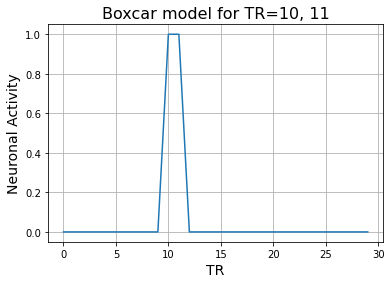

In [6]:
# BOXCAR
boxcar = np.array(
    [0] * 10 +
    [1] * 2  +
    [0] * 18
)

# PLOT
plt.plot(boxcar)
plt.title('Boxcar model for TR=10, 11', fontsize=16)
plt.xlabel('TR', fontsize=14)
plt.ylabel('Neuronal Activity', fontsize=14)
plt.grid()
plt.show()

### 0.b Consider the 0-20s, (i.e. 0 - 9 TRs) and 40-60s(i.e. 20 - 29 TRs) as baseline period.

Since baseilne period should be made by task and subject all respectively(making 11 * 4, which is too many), I'll make a function for this, so I can get the baseline whenever I want

In [7]:
baseline = lambda task, sub_id: (sum(BOLD[task][sub_id][0:10]) + sum(BOLD[task][sub_id][20:])) / 20

In [8]:
baseline_voxel = lambda task, sub_id: [(sum(voxel[0:10]) + sum(voxel[20:])) / 20 for voxel in BOLD_voxel[task][sub_id]]

For example, if I want to get the baseline of subject 02's auditory task baseline BOLD signal, just type - 

In [9]:
baseline('ad', '02')

713.3565548706055

In [10]:
baseline_voxel('lh', '02')

[595.3106323242188,
 545.4521759033203,
 629.6977447509765,
 632.8553894042968,
 641.8268981933594,
 631.5431304931641,
 633.347055053711,
 613.9210021972656,
 597.8236053466796,
 558.8818389892579,
 649.0997131347656,
 637.2162536621094,
 636.2021636962891,
 642.8617523193359,
 638.8408294677735,
 640.4305206298828,
 626.8262786865234,
 623.5722198486328,
 609.7802337646484,
 602.1404449462891,
 607.2271362304688,
 593.7396728515625,
 605.6336212158203,
 602.9740264892578,
 637.3285034179687,
 628.9061920166016,
 627.1052459716797,
 662.2691802978516,
 646.417446899414,
 639.1002014160156,
 639.2223937988281,
 643.4270874023438,
 650.4763854980469,
 646.0974731445312,
 646.3701446533203,
 649.3315612792969,
 639.4988708496094,
 637.5763610839844,
 639.2112762451172,
 643.6173675537109,
 646.334326171875,
 625.1027252197266,
 616.8119934082031,
 617.6345367431641,
 622.3939239501954,
 621.0926025390625,
 608.8688140869141,
 674.5185791015625,
 653.3820739746094,
 637.7266906738281,
 62

### 0.c Calculate the percentage(%) BOLD (pBOLD) signal based on (b)

In [11]:
def pBOLD(task, sub_id):
    
    base = baseline(task, sub_id)
    return (BOLD[task][sub_id] - base) / base * 100

In [12]:
def pBOLD_voxel(task, sub_id):
    
    base = baseline_voxel(task, sub_id)
    return ((BOLD_voxel[task][sub_id].T - base) / base * 100).T

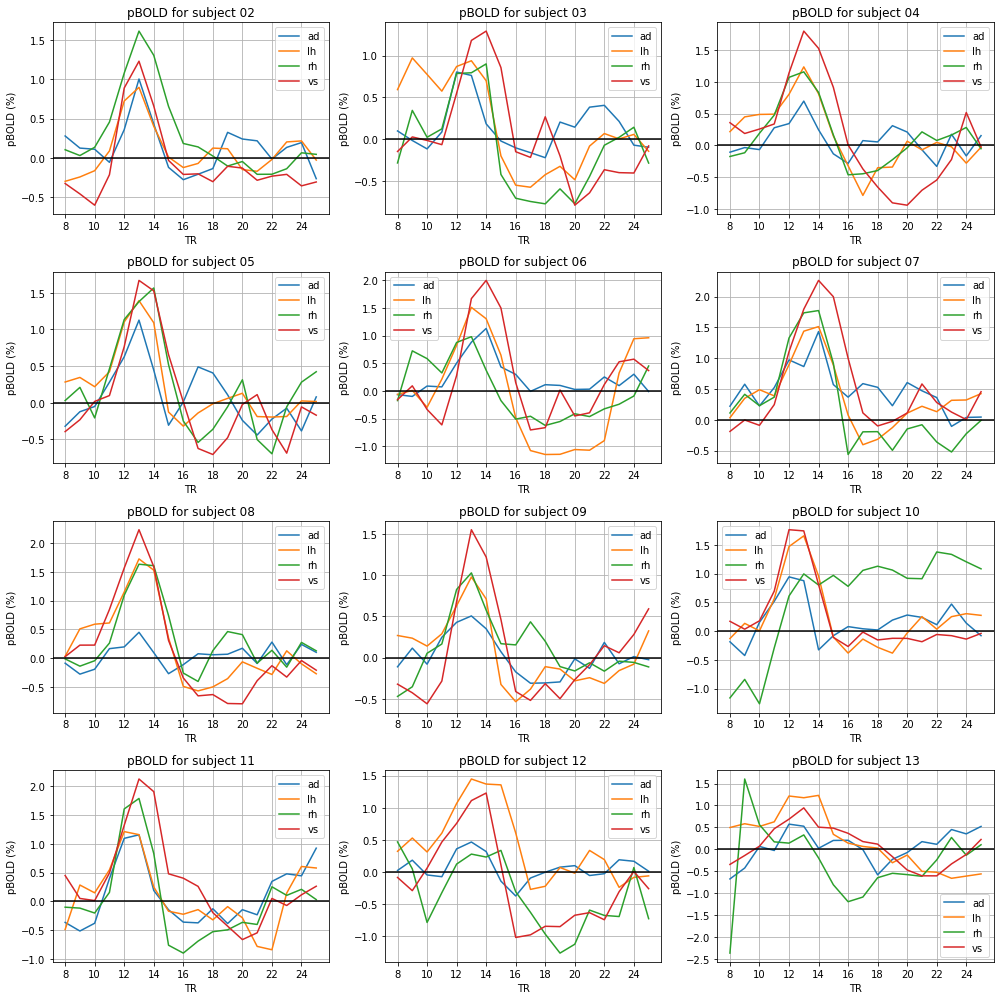

In [13]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(14, 14))
for sub_id in sub_ids:
    
    row, col = (sub_id - 2) // 3, (sub_id - 2) % 3
    sub_id = f'{str(sub_id).zfill(2)}'
    for task in tasks:
        axes[row, col].plot(pBOLD(task, sub_id)[8:26], label=task)
        
    axes[row, col].grid()
    axes[row, col].set_title(f'pBOLD for subject {sub_id}')
    axes[row, col].set_xlabel('TR')
    axes[row, col].set_xticks(np.arange(0, 18, step=2))
    axes[row, col].set_xticklabels([f'{i+8}' for i in range(0, 18) if not i % 2])
    axes[row, col].set_ylabel('pBOLD (%)')
    axes[row, col].axhline(0, color='black')
    axes[row, col].legend()
    
fig.tight_layout()

I drew an `y=0` in order to clearly see the baseline.

### 0.d Conduct the estimation of HRFs using the pBOLD signals calculated in (c) by applying each of the following methods [1] - [4]

Now we conduct the estimation.

# [1] Deconvolution Approach

### 1.a Set the reasonable number of Fast Fourier Transform (FFT) points

### 1.b Perform the FFT and inverse FFT to estimate the HRF in the time domain for each of the voxels in the ROI

### 1.c Check the estimated HRFs across the voxels and average the estimated HRFs

### 1.d Evaluate your results by comparing the average estimated HRF and average pBOLD signal

# [2] Using a flexible mathematical model of HRF - One Gamma Function

### 2.a Set the reasonable range of values as a grid for each of the parameters (i.e. $T_0$, $n$, and $\lambda$)

I'll denote the variables as follows
+ $T_0$ as `T0`
+ $n$ as `n`
+ $\lambda$ as `l`

In [14]:
params_one = {
    'T0': [0],
    'n' : [i * .01 for i in range(200, 400)],
    'l' : [i * .001 for i in range(1000, 2000)]
}

### 2.b Calculate Pearsons's correlation coefficients(CC) between the pBOLD signal and estimated pBOLD from the modeled HRF across all combinatorial sets of model parameters for *each voxel*

Phew, there are much things to be done here.
1. Make `one_gamma` function - *remember to use TR=9~25 only*
2. Get combintaions of parameter grids
3. Calculate Pearson's Correlation

### 2.1 Make `one_gamma` function

In [15]:
fact = math.factorial
def one_gamma(params: list, t=None):
    
    t0, n, lamb = params
    if t is None: t = np.arange(0, 18)
    return (t - t0)**(n-1) / (lamb**n * math.gamma(n)) * np.exp(-t/lamb)

In [38]:
def two_gamma(params: list, t=None):

    t0, n1, l1, a, n2, l2 = params
    if t is None:
        t = np.arange(0, 18)
    
    term1 = (t - t0)**(n1-1) / (l1**n1 * math.gamma(n1)) * np.exp(-t/l1)
    term2 = (t - t0)**(n2-1) / (l2**n2 * math.gamma(n2)) * np.exp(-t/l2)
    return term1- a * term2

See if it looks fine

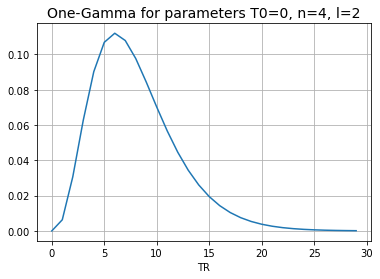

In [16]:
plt.plot(one_gamma([0, 4, 2], t=np.arange(0, 30)))
plt.title('One-Gamma for parameters T0=0, n=4, l=2', fontsize=14)
plt.xlabel('TR')
plt.grid()

### 2.2 Get combinations of parameter grid

Since there are too many cases of parameters to consider, I can't iterate them all by myself. Make a function for this.

In [17]:
cases = lambda cases: list(product(*cases.values()))

So that it conatins all the set of parameters seen as below

In [18]:
cases(params_one)

[(0, 2.0, 1.0),
 (0, 2.0, 1.0010000000000001),
 (0, 2.0, 1.002),
 (0, 2.0, 1.0030000000000001),
 (0, 2.0, 1.004),
 (0, 2.0, 1.0050000000000001),
 (0, 2.0, 1.006),
 (0, 2.0, 1.0070000000000001),
 (0, 2.0, 1.008),
 (0, 2.0, 1.0090000000000001),
 (0, 2.0, 1.01),
 (0, 2.0, 1.0110000000000001),
 (0, 2.0, 1.012),
 (0, 2.0, 1.0130000000000001),
 (0, 2.0, 1.014),
 (0, 2.0, 1.0150000000000001),
 (0, 2.0, 1.016),
 (0, 2.0, 1.0170000000000001),
 (0, 2.0, 1.018),
 (0, 2.0, 1.0190000000000001),
 (0, 2.0, 1.02),
 (0, 2.0, 1.0210000000000001),
 (0, 2.0, 1.022),
 (0, 2.0, 1.0230000000000001),
 (0, 2.0, 1.024),
 (0, 2.0, 1.025),
 (0, 2.0, 1.026),
 (0, 2.0, 1.027),
 (0, 2.0, 1.028),
 (0, 2.0, 1.029),
 (0, 2.0, 1.03),
 (0, 2.0, 1.031),
 (0, 2.0, 1.032),
 (0, 2.0, 1.033),
 (0, 2.0, 1.034),
 (0, 2.0, 1.035),
 (0, 2.0, 1.036),
 (0, 2.0, 1.037),
 (0, 2.0, 1.038),
 (0, 2.0, 1.039),
 (0, 2.0, 1.04),
 (0, 2.0, 1.041),
 (0, 2.0, 1.042),
 (0, 2.0, 1.043),
 (0, 2.0, 1.044),
 (0, 2.0, 1.045),
 (0, 2.0, 1.046),
 (0,

with each case, I can make HRF. Let's plot some sampling from cases.

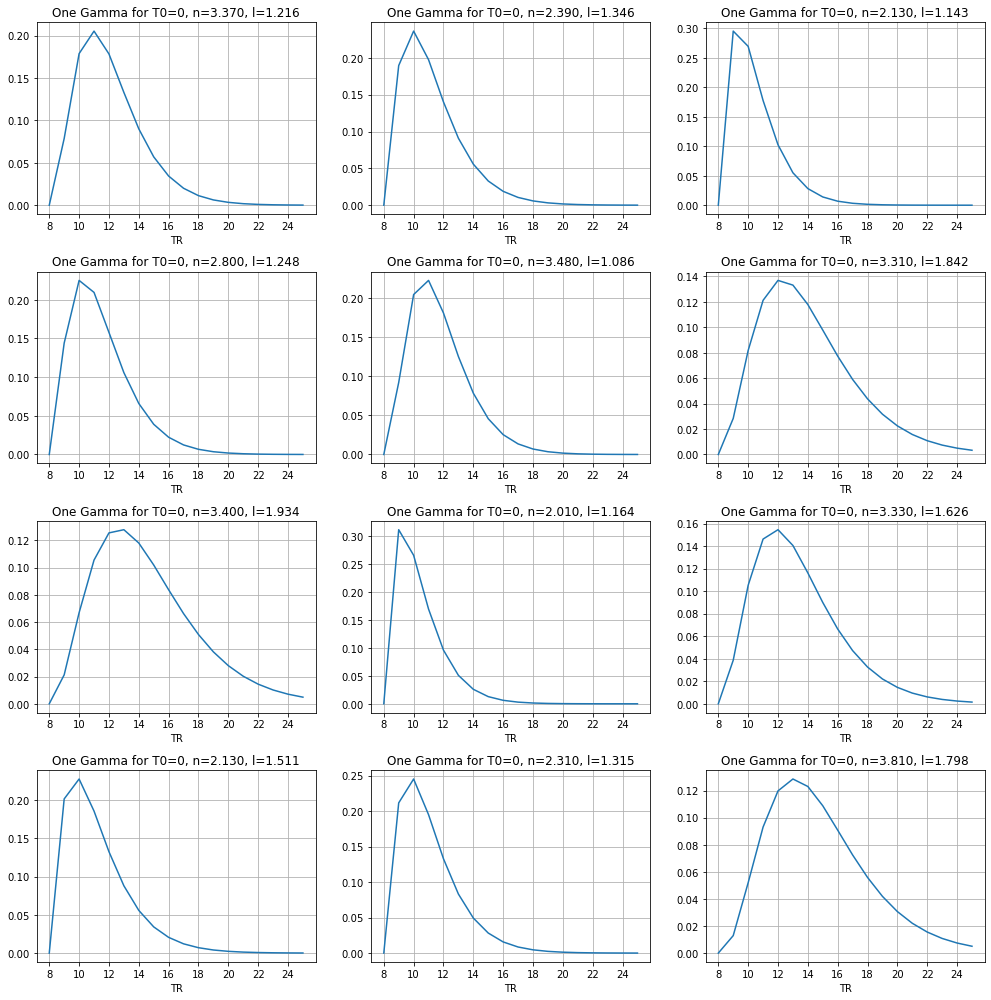

In [45]:
fig, axes = plt.subplots(4, 3, figsize=(14, 14))
for i in range(12):
    
    row, col = i // 3, i % 3
    sample = random.choice(cases(params_one))
    
    axes[row, col].plot(one_gamma(sample))
    T0, n, l = sample
    axes[row, col].set_title(f'One Gamma for T0={T0}, n={n:.3f}, l={l:.3f}')
    axes[row, col].set_xlabel('TR')
    axes[row, col].set_xticks(np.arange(0, 18, step=2))
    axes[row, col].set_xticklabels([f'{i+8}' for i in range(0, 18) if not i % 2])
    axes[row, col].grid()
    
fig.tight_layout()

### 2.3 Calculate Correlations

In [20]:
corr = lambda bold, hrf: np.corrcoef(bold[8:26], hrf)[0][1]

In [21]:
corr(pBOLD('ad', '02'), one_gamma(sample))

0.33018991318724816

In [22]:
corr_voxel = lambda bold_voxel, hrf:[np.corrcoef(voxel[8:26], hrf)[0][1] for voxel in bold_voxel]

In [23]:
corr_voxel(pBOLD_voxel('ad', '02'), one_gamma(sample))

[0.39953343488329235,
 0.44891819860979487,
 0.40909770831670744,
 0.4003219523948967,
 0.48260700216285574,
 0.46643449745430937,
 0.4512043872356649,
 0.41865534324503306,
 0.48634745309622035,
 0.24802760257161774,
 0.08070029457593661,
 0.32559837040542045,
 0.25274185017811873,
 0.33681339522889314,
 0.40662083306301966,
 0.17955240016607305,
 0.4251285074101229,
 0.12160962015045644,
 0.09269391951685889,
 0.014879461281382953,
 0.08466650306384613,
 0.15994584303489534,
 0.13642403909444753,
 -0.01877538796206878,
 0.19864661205032044,
 -0.02860629759823303,
 0.21087207600860083,
 0.4038140595337265,
 0.11525965530775883,
 0.18121859142365804]

In [54]:
zfill = lambda x: str(x).zfill(2)
def get_corr_voxel(task, params):

    if len(params) == 3:
        hrf = one_gamma(params)
        
    elif len(params) ==  6:
        hrf = two_gamma(params)
        
    return pd.DataFrame({
            f'{zfill(sub_id)}': corr_voxel(pBOLD_voxel(task, f'{zfill(sub_id)}'), hrf)
            for sub_id in sub_ids
        })

Now I can draw a heatmap of correlations for each -
+ task
+ subject
+ voxels of interest   

For, example

(0, 3.54, 1.562)


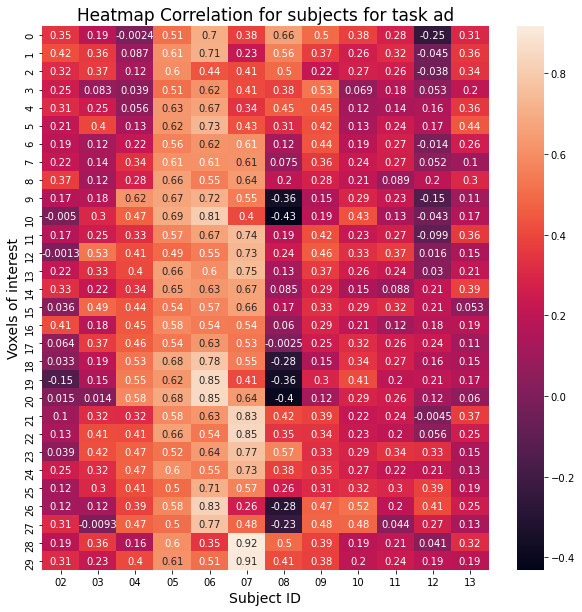

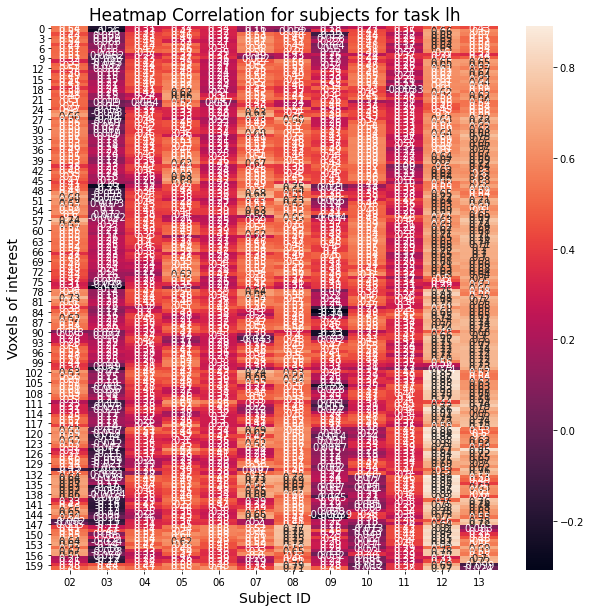

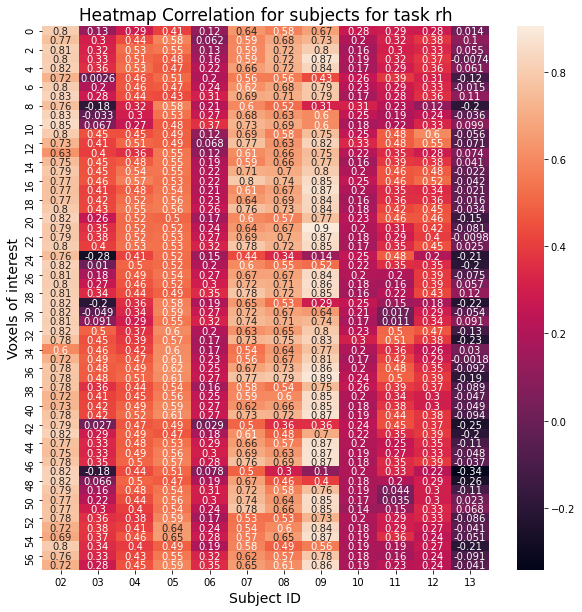

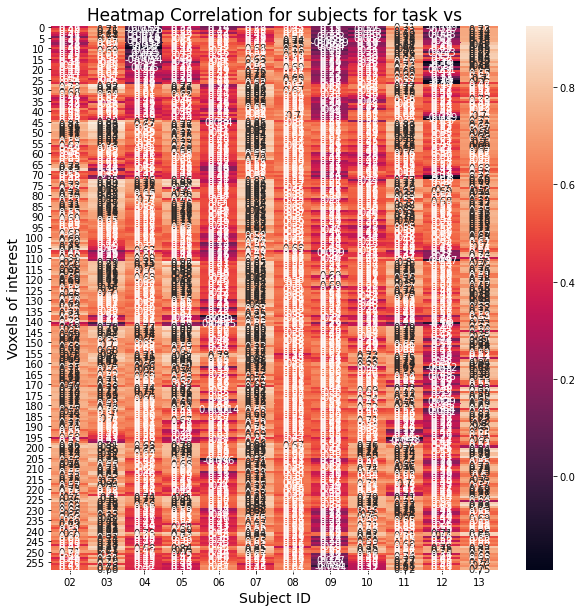

In [83]:
print(sample)
for task in tasks:
    plt.figure(figsize=(10, 10))
    sns.heatmap(get_corr_voxel(task, sample), annot=True)
    plt.title(f'Heatmap Correlation for subjects for task {task}', fontsize=17)
    plt.ylabel('Voxels of interest', fontsize=14)
    plt.xlabel('Subject ID', fontsize=14)
    plt.show()

### 2.c Calculate the average CC across all voxels within an ROI for each of the parameter set and choose the optimal parameter set that showed the maximum average CC. The HRF obtained from the optimal parameter set is the estimated HRF of the pBOLD signal.

In [99]:
best_corr = [0, 0] # [idx, corr]
for comb in cases(params_one):
    corr_case = get_corr_voxel(task, comb).mean().mean()
    if best_corr[1] + .01 < corr_case:
        best_corr[1] = corr_case
        best_corr[0] = comb
        print(f'T0: {comb[0]:.3f}, n: {comb[1]:.3f}, l: {comb[2]:.3f} :: Corr: {best_corr[1]}')

T0: 0.000, n: 2.000, l: 1.000 :: Corr: 0.1854479842206128
T0: 0.000, n: 2.000, l: 1.014 :: Corr: 0.1956147557104925
T0: 0.000, n: 2.000, l: 1.028 :: Corr: 0.20573199916275006
T0: 0.000, n: 2.000, l: 1.042 :: Corr: 0.21578960526623633
T0: 0.000, n: 2.000, l: 1.057 :: Corr: 0.22648859867085314
T0: 0.000, n: 2.000, l: 1.072 :: Corr: 0.2370971440962594
T0: 0.000, n: 2.000, l: 1.087 :: Corr: 0.2476049187238666
T0: 0.000, n: 2.000, l: 1.102 :: Corr: 0.2580022954439636
T0: 0.000, n: 2.000, l: 1.117 :: Corr: 0.26828032359203474
T0: 0.000, n: 2.000, l: 1.132 :: Corr: 0.2784307084826873
T0: 0.000, n: 2.000, l: 1.147 :: Corr: 0.2884457899932226
T0: 0.000, n: 2.000, l: 1.163 :: Corr: 0.29897147960835435
T0: 0.000, n: 2.000, l: 1.179 :: Corr: 0.30932739836929074
T0: 0.000, n: 2.000, l: 1.195 :: Corr: 0.3195064632748474
T0: 0.000, n: 2.000, l: 1.212 :: Corr: 0.3301208121605174
T0: 0.000, n: 2.000, l: 1.229 :: Corr: 0.3405214792163595
T0: 0.000, n: 2.000, l: 1.246 :: Corr: 0.3507024395715775
T0: 0.00

KeyboardInterrupt: 

In [94]:
None > 1

TypeError: '>' not supported between instances of 'NoneType' and 'int'

### 2.d Evaluate your results by comparing the estimated HRFs, estimated pBOLD signal, and average pBOLD signal.

In [ ]:
best_params = best_corr[0]
estimated_hrf = 
random.choice

## 3. Using a flexible model of HRF two gamma functions
Follow similar steps in [2] with difference in the adjustable parameters for the two gamma functions(i.e. $T_0$, $n_1$, $\lambda_1$, $a$, $n_2$, $\lambda_2$)

In [25]:
params_two = {
    'T0': [0],
    'n1' : [i * .01 for i in range(200, 400, 5)],
    'l1' : [i * .01 for i in range(100, 200, 5)],
    'a'  : [i * .01 for i in range(2, 10, 2)],
    'n2' : [i * .01 for i in range(200, 400, 5)],
    'l2' : [i * .01 for i in range(100, 200, 5)],
}

In [38]:
def two_gamma(params: list, t=None):

    t0, n1, l1, a, n2, l2 = params
    if t is None:
        t = np.arange(0, 18)
    
    term1 = (t - t0)**(n1-1) / (l1**n1 * math.gamma(n1)) * np.exp(-t/l1)
    term2 = (t - t0)**(n2-1) / (l2**n2 * math.gamma(n2)) * np.exp(-t/l2)
    return term1- a * term2

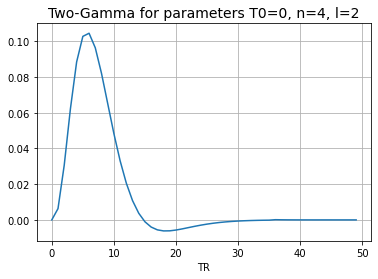

In [40]:
plt.plot(two_gamma([0, 4, 2, .3, 7, 2], t=np.arange(0, 50)))
plt.title('Two-Gamma for parameters T0=0, n=4, l=2', fontsize=14)
plt.xlabel('TR')
plt.grid()

In [26]:
cases(params_two)

[(0, 2.0, 1.0, 0.02, 2.0, 1.0),
 (0, 2.0, 1.0, 0.02, 2.0, 1.05),
 (0, 2.0, 1.0, 0.02, 2.0, 1.1),
 (0, 2.0, 1.0, 0.02, 2.0, 1.1500000000000001),
 (0, 2.0, 1.0, 0.02, 2.0, 1.2),
 (0, 2.0, 1.0, 0.02, 2.0, 1.25),
 (0, 2.0, 1.0, 0.02, 2.0, 1.3),
 (0, 2.0, 1.0, 0.02, 2.0, 1.35),
 (0, 2.0, 1.0, 0.02, 2.0, 1.4000000000000001),
 (0, 2.0, 1.0, 0.02, 2.0, 1.45),
 (0, 2.0, 1.0, 0.02, 2.0, 1.5),
 (0, 2.0, 1.0, 0.02, 2.0, 1.55),
 (0, 2.0, 1.0, 0.02, 2.0, 1.6),
 (0, 2.0, 1.0, 0.02, 2.0, 1.6500000000000001),
 (0, 2.0, 1.0, 0.02, 2.0, 1.7),
 (0, 2.0, 1.0, 0.02, 2.0, 1.75),
 (0, 2.0, 1.0, 0.02, 2.0, 1.8),
 (0, 2.0, 1.0, 0.02, 2.0, 1.85),
 (0, 2.0, 1.0, 0.02, 2.0, 1.9000000000000001),
 (0, 2.0, 1.0, 0.02, 2.0, 1.95),
 (0, 2.0, 1.0, 0.02, 2.05, 1.0),
 (0, 2.0, 1.0, 0.02, 2.05, 1.05),
 (0, 2.0, 1.0, 0.02, 2.05, 1.1),
 (0, 2.0, 1.0, 0.02, 2.05, 1.1500000000000001),
 (0, 2.0, 1.0, 0.02, 2.05, 1.2),
 (0, 2.0, 1.0, 0.02, 2.05, 1.25),
 (0, 2.0, 1.0, 0.02, 2.05, 1.3),
 (0, 2.0, 1.0, 0.02, 2.05, 1.35),
 (0, 2.0, 

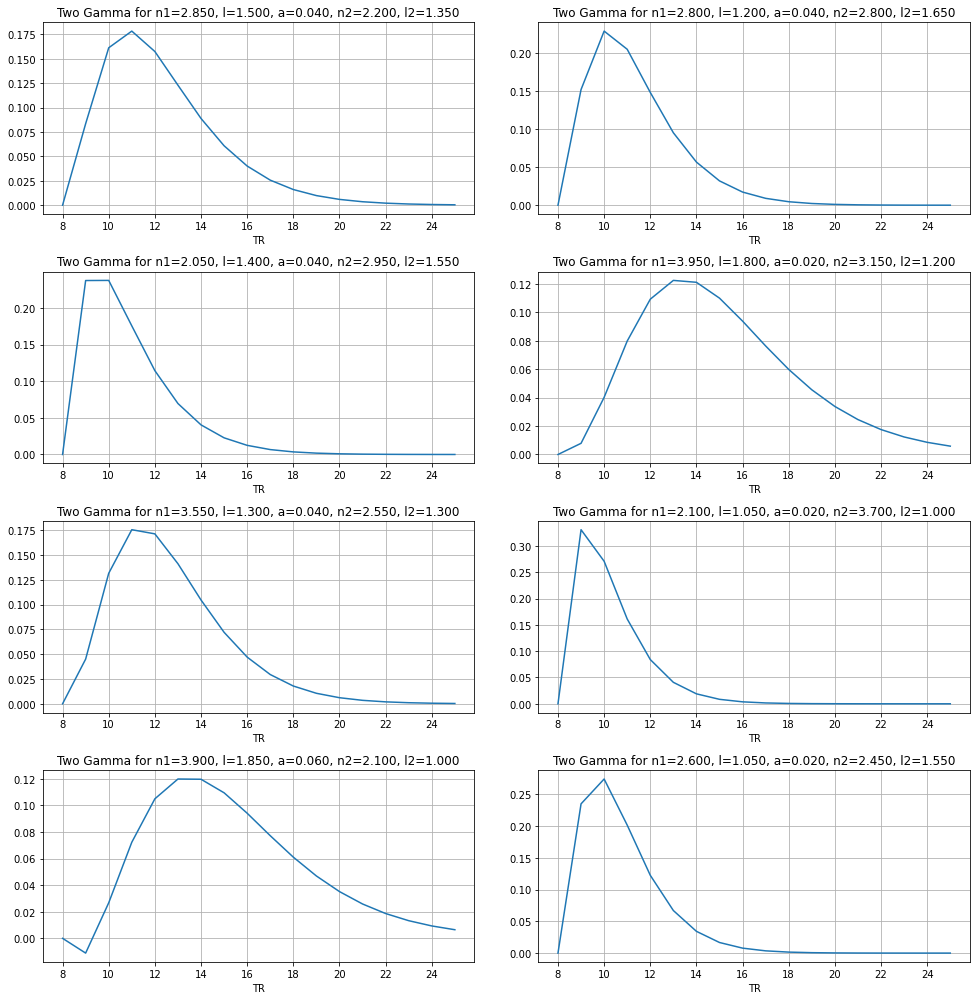

In [44]:
fig, axes = plt.subplots(4, 2, figsize=(14, 14))
for i in range(8):
    
    row, col = i // 2, i % 2
    sample = random.choice(cases(params_two))
    
    axes[row, col].plot(two_gamma(sample))
    T0, n1, l1, a, n2, l2 = sample
    axes[row, col].set_title(f'Two Gamma for n1={n1:.3f}, l1={l1:.3f}, a={a:.3f}, n2={n2:.3f}, l2={l2:.3f}')
    axes[row, col].set_xlabel('TR')
    axes[row, col].set_xticks(np.arange(0, 18, step=2))
    axes[row, col].set_xticklabels([f'{i+8}' for i in range(0, 18) if not i % 2])
    axes[row, col].grid()
    
fig.tight_layout()

(0, 3.81, 1.798)


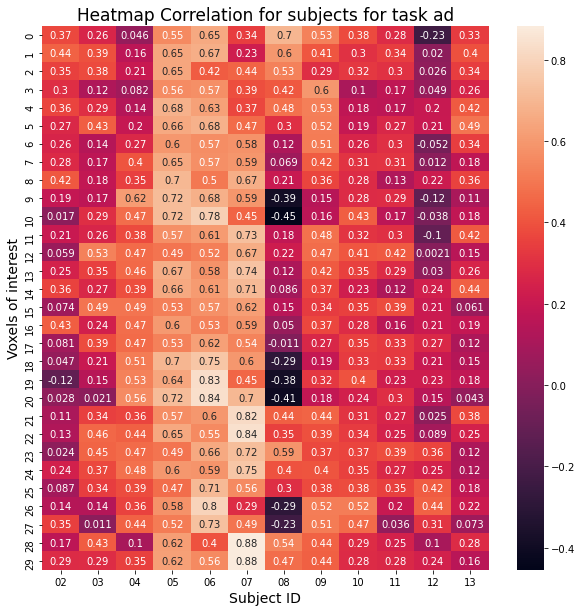

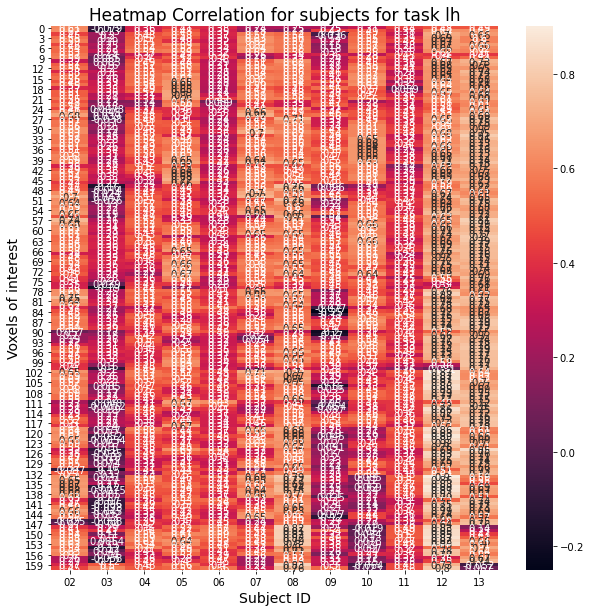

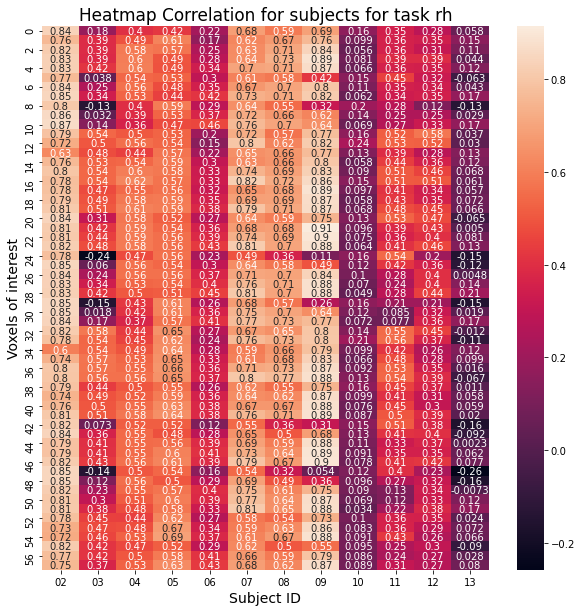

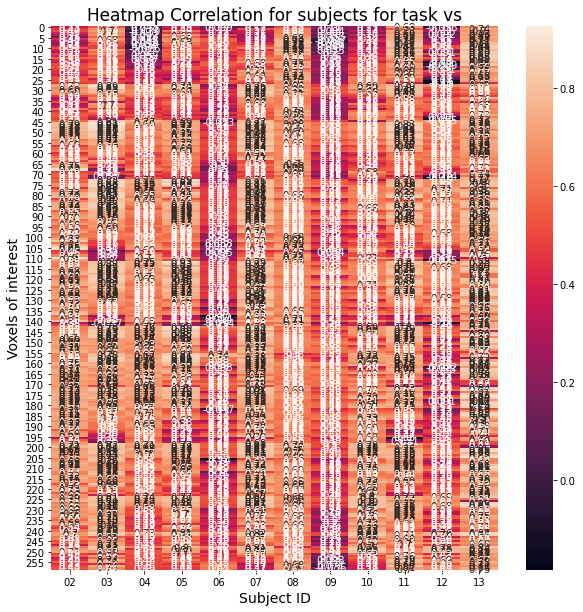

In [47]:
print(sample)
for task in tasks:
    plt.figure(figsize=(10, 10))
    sns.heatmap(get_corr_voxel(task, sample), annot=True)
    plt.title(f'Heatmap Correlation for subjects for task {task}', fontsize=17)
    plt.ylabel('Voxels of interest', fontsize=14)
    plt.xlabel('Subject ID', fontsize=14)
    plt.show()

## [4] Based on the model with three fixed gamma function (Friston et al., 1998) using least-squares(LS) algorithm

### 4.a Study the LS algorithm and show your work

I got the idea of LS algorithm as a gradient method that checks its gradient with loss of Least squares, so as to say MSE(Mean Squared Loss). I made this algorithm by myself.

In [66]:
SSE = lambda true, pred: sum(np.square(true - pred)) / len(true)

In [48]:
def partial_difference_quotient(func, v, i, h=1e-9):
    
    w = [v_j + (h if j==i else 0) for j, v_j in enumerate(v)]
    return (func(w) - func(v)) / h

In [49]:
def gradient_estimate(func, v, h=1e-9):
    
    return [partial_difference_quotient(func, v, i, h) for i, _ in enumerate(v)]

In [60]:
def one_gamma_loss(params):
    
    task = 'ad'
    true = sum(pBOLD(task, zfill(sub_id)) for sub_id in sub_ids)[8:26]
    pred = one_gamma(params)
    return np.sum(np.square(true - pred)) / len(true)

In [172]:
class LeastSquares:
    
    def __init__(self, epochs, task, gamma_type, init_params, lr):
        
        self.epochs = epochs
        self.task   = task
        self.gamma = one_gamma if gamma_type == 1 else two_gamma
        self.init_params = init_params
        self.lr = lr
        self.true = sum(pBOLD(self.task, zfill(sub_id)) for sub_id in sub_ids)[8:26]
        self.true /= sum(self.true)
        
    def fit(self):
        
        params = self.init_params
        self.losses = []
        for e in range(self.epochs):
            
            print(f'{str(e):<5} th Epochs')
            pred = self.gamma(params)
            loss = SSE(self.true, pred)
            self.losses.append(loss)
            
            print(f'Prediction:: {pred}')
            
            params = list(map(lambda w, g: w - g * self.lr, params, gradient_estimate(self.mse, params)))
            print(f'LOSS:: {loss}, Gradient:: {params}')
            params = [0] + params[1:]
            print('\n')
            
        self.params = params
            
    def mse(self, params):
        
        true = self.true
        pred = self.gamma(params)
        return np.sum(np.square(true - pred)) / len(true)
            
        
    def plot_loss(self):
        
        plt.figure(figsize=(7, 7))
        plt.plot(self.losses)
        plt.title(f'MSE Loss among {self.epochs} epochs', fontsize=16)
        plt.xlabel('Epochs')
        plt.ylabel('MSE Loss')
        plt.grid()
        
    
    def plot_gamma(self, params=None):
        
        if params is None:
            params = self.params
            
        if len(params) == 3:
            T0, n, l = params
            ttl = f'Params of  T0={T0}, n={n:.3f}, l={l:.3f}'
            
        elif len(params) == 6:
            T0, n1, l1, a, n2, l2 = params
            ttl = f'Params of n1={n1:.3f}, l1={l1:.3f}, a={a:.3f}, n2={n2:.3f}, l2={l2:.3f}'
            
            
        plt.plot(self.gamma(params))
        plt.plot(self.true)
        plt.title(ttl)
        plt.xlabel('TR')
        plt.grid()

In [173]:
one = LeastSquares(10000, 'ad', 1, (0, 4, 2), 1e-2)
one.fit()

0     th Epochs
Prediction:: [0.         0.00631803 0.03065662 0.06275536 0.09022352 0.10688151
 0.1120209  0.10789273 0.09768341 0.08435894 0.07018695 0.05666138
 0.04461754 0.03440683 0.02606463 0.01944437 0.01431307 0.01041292]
LOSS:: 0.007001869280381757, Gradient:: [-1.4182327187639565e-05, 3.999977242804566, 1.999962965310449]


1     th Epochs
Prediction:: [0.         0.00631872 0.0306592  0.06275948 0.09022802 0.1068853
 0.11202338 0.10789374 0.09768312 0.08435769 0.07018508 0.05665923
 0.04461534 0.03440476 0.02606277 0.01944278 0.01431174 0.01041184]
LOSS:: 0.007001680334432757, Gradient:: [nan, 3.9999544862856746, 1.9999259301265015]


2     th Epochs
Prediction:: [0.         0.00631941 0.03066178 0.0627636  0.09023252 0.1068891
 0.11202586 0.10789475 0.09768283 0.08435643 0.07018322 0.05665708
 0.04461315 0.03440268 0.02606091 0.01944118 0.01431042 0.01041076]
LOSS:: 0.007001491387851327, Gradient:: [nan, 3.9999317304433255, 1.9998888944308109]


3     th Epochs
Prediction:

<ipython-input-15-599e083d0b1d>:6: RuntimeWarning: invalid value encountered in power
  return (t - t0)**(n-1) / (lamb**n * math.gamma(n)) * np.exp(-t/lamb)


LOSS:: 0.00696028835660275, Gradient:: [nan, 3.994987343703013, 1.991803371632653]


221   th Epochs
Prediction:: [0.         0.00647225 0.03123167 0.06367156 0.09122095 0.10772041
 0.11256516 0.10811052 0.09761403 0.0840761  0.06977098 0.05618295
 0.04413062 0.03394777 0.02565447 0.01909245 0.0140206  0.01017608]
LOSS:: 0.006960099310580332, Gradient:: [nan, 3.994964739596926, 1.991766229789233]


222   th Epochs
Prediction:: [0.         0.00647295 0.0312343  0.06367573 0.09122548 0.10772421
 0.11256761 0.10811148 0.09761369 0.0840748  0.06976908 0.05618078
 0.0441284  0.03394569 0.02565262 0.01909086 0.01401928 0.01017501]
LOSS:: 0.006959910264282187, Gradient:: [nan, 3.9949421361847284, 1.9917290874774374]


223   th Epochs
Prediction:: [0.         0.00647366 0.03123692 0.0636799  0.09123001 0.10772801
 0.11257006 0.10811244 0.09761335 0.0840735  0.06976718 0.0561786
 0.04412619 0.03394361 0.02565076 0.01908928 0.01401796 0.01017395]
LOSS:: 0.006959721217702307, Gradient:: [nan, 3.9

LOSS:: 0.0069149157340229125, Gradient:: [nan, 3.989583154497496, 1.9828765119211647]


461   th Epochs
Prediction:: [0.         0.0066438  0.03186752 0.06467929 0.09231186 0.10863145
 0.11314935 0.10833595 0.09752633 0.08375759 0.06931026 0.05565727
 0.0435985  0.03344824 0.02520981 0.01871219 0.01370555 0.00992171]
LOSS:: 0.006914726695583359, Gradient:: [nan, 3.9895607261015495, 1.982839264788703]


462   th Epochs
Prediction:: [0.         0.00664452 0.03187019 0.06468351 0.09231642 0.10863525
 0.11315177 0.10833686 0.09752594 0.08375623 0.06930832 0.05565507
 0.04359627 0.03344616 0.02520796 0.01871061 0.01370424 0.00992066]
LOSS:: 0.006914537657497071, Gradient:: [nan, 3.989538298468882, 1.982802017213887]


463   th Epochs
Prediction:: [0.         0.00664525 0.03187286 0.06468774 0.09232098 0.10863904
 0.11315418 0.10833778 0.09752555 0.08375488 0.06930638 0.05565287
 0.04359405 0.03344407 0.02520611 0.01870903 0.01370294 0.0099196 ]
LOSS:: 0.006914348619622995, Gradient:: [nan, 

LOSS:: 0.006867104259293114, Gradient:: [nan, 3.9839332435330683, 1.9734403573984909]


714   th Epochs
Prediction:: [0.         0.00682928 0.03255059 0.06575574 0.09347012 0.1095913
 0.11375695 0.10856078 0.09741982 0.08340907 0.06881464 0.05509652
 0.04303412 0.03292085 0.0247422  0.01831373 0.01337651 0.00965688]
LOSS:: 0.006866915365581433, Gradient:: [nan, 3.983911011230264, 1.9734030123148683]


715   th Epochs
Prediction:: [0.         0.00683003 0.03255332 0.06576003 0.09347472 0.1095951
 0.11375933 0.10856164 0.09741937 0.08340767 0.06881267 0.05509429
 0.04303189 0.03291876 0.02474035 0.01831216 0.01337522 0.00965584]
LOSS:: 0.006866726472763317, Gradient:: [nan, 3.9838887797167586, 1.97336566685828]


716   th Epochs
Prediction:: [0.         0.00683077 0.03255604 0.06576431 0.09347931 0.10959889
 0.11376171 0.1085625  0.09741892 0.08340627 0.06881069 0.05509206
 0.04302965 0.03291668 0.02473851 0.01831059 0.01337392 0.0096548 ]
LOSS:: 0.006866537580736463, Gradient:: [nan, 3.

LOSS:: 0.0068236858080444485, Gradient:: [nan, 3.9788411634508236, 1.9648419542371536]


944   th Epochs
Prediction:: [0.         0.00700208 0.03318293 0.06674671 0.09453001 0.11046291
 0.11430153 0.10875347 0.09731037 0.08308098 0.06835544 0.05458113
 0.0425183  0.03244098 0.02431835 0.01795383 0.01308029 0.00941921]
LOSS:: 0.006823497171340927, Gradient:: [nan, 3.9788191191573494, 1.9648045322185448]


945   th Epochs
Prediction:: [0.         0.00700284 0.0331857  0.06675104 0.09453463 0.11046669
 0.11430388 0.10875428 0.09730987 0.08307953 0.06835343 0.05457888
 0.04251605 0.03243889 0.02431651 0.01795227 0.01307901 0.00941818]
LOSS:: 0.006823308535892769, Gradient:: [nan, 3.9787970757052165, 1.9647671099137065]


946   th Epochs
Prediction:: [0.         0.0070036  0.03318848 0.06675538 0.09453926 0.11047048
 0.11430623 0.10875509 0.09730937 0.08307808 0.06835142 0.05457663
 0.0425138  0.0324368  0.02431468 0.01795071 0.01307773 0.00941715]
LOSS:: 0.006823119901920708, Gradient:: [n

 0.04189174 0.03186081 0.02380801 0.01752207 0.01272616 0.009136  ]
LOSS:: 0.006771118108501359, Gradient:: [nan, 3.9727239317556786, 1.9543900664791134]


1223  th Epochs
Prediction:: [0.         0.00721706 0.03396445 0.06796424 0.09582393 0.11151823
 0.11495159 0.10897189 0.09716138 0.08266871 0.06778767 0.05394919
 0.04188948 0.03185872 0.02380618 0.01752053 0.01272489 0.00913498]
LOSS:: 0.006770929948210691, Gradient:: [nan, 3.9727021281030455, 1.9543525673000044]


1224  th Epochs
Prediction:: [0.         0.00721784 0.03396728 0.06796863 0.09582858 0.111522
 0.1149539  0.10897264 0.09716082 0.08266721 0.06778562 0.05394691
 0.04188722 0.03185663 0.02380435 0.01751898 0.01272362 0.00913397]
LOSS:: 0.006770741789925383, Gradient:: [nan, 3.972680325317774, 1.954315067878034]


1225  th Epochs
Prediction:: [0.         0.00721862 0.03397011 0.06797303 0.09583324 0.11152578
 0.11495621 0.10897339 0.09716025 0.0826657  0.06778356 0.05394463
 0.04188497 0.03185455 0.02380251 0.01751744 0.

LOSS:: 0.006725085558297737, Gradient:: [nan, 3.967408986379508, 1.945196057530864]


1468  th Epochs
Prediction:: [0.         0.00741073 0.03466372 0.069047   0.09696702 0.11244251
 0.11551238 0.10914953 0.09701582 0.08229394 0.06727968 0.05338851
 0.04133489 0.03134765 0.0233585  0.01714324 0.01241654 0.00888923]
LOSS:: 0.006724897969168336, Gradient:: [nan, 3.9673874054566953, 1.9451585057896337]


1469  th Epochs
Prediction:: [0.         0.00741153 0.0346666  0.06905145 0.09697169 0.11244628
 0.11551465 0.10915023 0.0970152  0.08229239 0.06727759 0.05338621
 0.04133262 0.03134557 0.02335668 0.01714171 0.01241529 0.00888823]
LOSS:: 0.006724710382794178, Gradient:: [nan, 3.9673658254359387, 1.94512095384891]


1470  th Epochs
Prediction:: [0.         0.00741233 0.03466948 0.0690559  0.09697637 0.11245004
 0.11551691 0.10915093 0.09701457 0.08229083 0.0672755  0.05338391
 0.04133035 0.03134348 0.02335486 0.01714018 0.01241404 0.00888724]
LOSS:: 0.006724522798933801, Gradient:: [nan, 3

1690  th Epochs
Prediction:: [0.         0.00759019 0.03530775 0.0700388  0.09800782 0.11327753
 0.11601197 0.10929883 0.096872   0.08194421 0.06681204 0.05287615
 0.04083073 0.03088505 0.02295479 0.01680417 0.0121403  0.00866974]
LOSS:: 0.006683322740602273, Gradient:: [nan, 3.9626198065889175, 1.936817897047788]


1691  th Epochs
Prediction:: [0.         0.00759101 0.03531067 0.07004329 0.09801252 0.11328128
 0.1160142  0.10929948 0.09687133 0.08194261 0.06680992 0.05287383
 0.04082846 0.03088296 0.02295298 0.01680265 0.01213906 0.00866876]
LOSS:: 0.006683135798637146, Gradient:: [nan, 3.962598437684008, 1.9367803102651435]


1692  th Epochs
Prediction:: [0.         0.00759183 0.0353136  0.07004778 0.09801722 0.11328504
 0.11601643 0.10930013 0.09687066 0.08194102 0.06680779 0.05287151
 0.04082618 0.03088088 0.02295116 0.01680113 0.01213783 0.00866778]
LOSS:: 0.006682948859797044, Gradient:: [nan, 3.9625770697505436, 1.9367427233350474]


1693  th Epochs
Prediction:: [0.         0.00

LOSS:: 0.006634832028119624, Gradient:: [nan, 3.9570971003295945, 1.9270417310946455]


1951  th Epochs
Prediction:: [0.         0.00780601 0.03607743 0.07121739 0.09923698 0.11425556
 0.11658844 0.10945993 0.09668843 0.0815209  0.06625366 0.05226892
 0.04023644 0.03034212 0.02248281 0.01640916 0.01181957 0.0084157 ]
LOSS:: 0.006634645996319941, Gradient:: [nan, 3.957075989881136, 1.9270041194100453]


1952  th Epochs
Prediction:: [0.         0.00780685 0.0360804  0.07122193 0.0992417  0.1142593
 0.11659063 0.10946052 0.0966877  0.08151926 0.0662515  0.05226659
 0.04023416 0.03034004 0.02248101 0.01640765 0.01181835 0.00841474]
LOSS:: 0.006634459968348876, Gradient:: [nan, 3.957054880456164, 1.9269665076734035]


1953  th Epochs
Prediction:: [0.         0.00780768 0.03608338 0.07122647 0.09924642 0.11426304
 0.11659281 0.10946111 0.09668696 0.08151761 0.06624934 0.05226425
 0.04023188 0.03033797 0.02247921 0.01640615 0.01181713 0.00841377]
LOSS:: 0.006634273944258517, Gradient:: [nan, 

LOSS:: 0.006593446331220119, Gradient:: [nan, 3.9524149834218694, 1.9186532784364714]


2174  th Epochs
Prediction:: [0.         0.00799455 0.03674562 0.07223477 0.10029135 0.11508752
 0.11707127 0.10958503 0.0965192  0.08114903 0.06576952 0.05174629
 0.03972765 0.02987936 0.02208208 0.01607497 0.01154911 0.00820217]
LOSS:: 0.006593261215912528, Gradient:: [nan, 3.952394104298786, 1.9186156595180743]


2175  th Epochs
Prediction:: [0.         0.0079954  0.03674864 0.07223935 0.10029608 0.11509124
 0.11707341 0.10958556 0.09651841 0.08114735 0.06576733 0.05174394
 0.03972537 0.02987729 0.02208029 0.01607347 0.01154791 0.00820122]
LOSS:: 0.006593076104997584, Gradient:: [nan, 3.9523732262425577, 1.918578040608351]


2176  th Epochs
Prediction:: [0.         0.00799626 0.03675166 0.07224393 0.10030082 0.11509496
 0.11707556 0.10958609 0.09651763 0.08114566 0.06576515 0.05174159
 0.03972309 0.02987521 0.0220785  0.01607198 0.0115467  0.00820027]
LOSS:: 0.006592890998541708, Gradient:: [nan,

LOSS:: 0.006544000803574399, Gradient:: [nan, 3.946857774067721, 1.9085721874137591]


2442  th Epochs
Prediction:: [0.         0.00822617 0.03756134 0.07346958 0.10156285 0.11608216
 0.11763916 0.10971984 0.09630078 0.08068998 0.06517949 0.05111401
 0.03911542 0.02932497 0.02160389 0.01567761 0.01122864 0.00794997]
LOSS:: 0.006543816957882268, Gradient:: [nan, 3.946837184669479, 1.9085345776026603]


2443  th Epochs
Prediction:: [0.         0.00822705 0.03756441 0.07347422 0.1015676  0.11608586
 0.11764126 0.10972032 0.09629993 0.08068824 0.06517728 0.05111164
 0.03911314 0.02932291 0.02160211 0.01567613 0.01122745 0.00794903]
LOSS:: 0.006543633117142252, Gradient:: [nan, 3.946816596390134, 1.9084969678869714]


2444  th Epochs
Prediction:: [0.         0.00822792 0.03756748 0.07347885 0.10157235 0.11608956
 0.11764335 0.10972079 0.09629909 0.0806865  0.06517506 0.05110927
 0.03911085 0.02932084 0.02160033 0.01567466 0.01122627 0.0079481 ]
LOSS:: 0.006543449281607922, Gradient:: [nan, 

LOSS:: 0.006502951095193076, Gradient:: [nan, 3.942273681604458, 1.9001498859550845]


2666  th Epochs
Prediction:: [0.         0.00842398 0.03825357 0.07451138 0.10262864 0.11690857
 0.11810308 0.10981938 0.0961057  0.08029636 0.06467984 0.05058241
 0.03860342 0.02886339 0.02120731 0.01534926 0.01096472 0.00774295]
LOSS:: 0.006502768452735682, Gradient:: [nan, 3.942253344192148, 1.90011229907703]


2667  th Epochs
Prediction:: [0.         0.00842487 0.03825668 0.07451605 0.1026334  0.11691225
 0.11810513 0.1098198  0.09610481 0.08029458 0.06467759 0.05058003
 0.03860113 0.02886134 0.02120554 0.0153478  0.01096355 0.00774204]
LOSS:: 0.0065025858158475995, Gradient:: [nan, 3.9422330079160823, 1.9000747123464272]


2668  th Epochs
Prediction:: [0.         0.00842576 0.03825979 0.07452072 0.10263817 0.11691592
 0.11810718 0.10982021 0.09610391 0.08029281 0.06467535 0.05057765
 0.03859885 0.02885928 0.02120378 0.01534635 0.01096238 0.00774112]
LOSS:: 0.006502403184657721, Gradient:: [nan, 

LOSS:: 0.006455300094680318, Gradient:: [nan, 3.9369849407702957, 1.8903075684038524]


2928  th Epochs
Prediction:: [0.         0.00866017 0.03907501 0.07574055 0.103878   0.11786878
 0.11863282 0.10992045 0.0958632  0.07982484 0.06408835 0.0499575
 0.03800468 0.02832597 0.02074735 0.01496981 0.01066076 0.00750529]
LOSS:: 0.006455119024848481, Gradient:: [nan, 3.9369649092764707, 1.8902700265418722]


2929  th Epochs
Prediction:: [0.         0.00866109 0.03907817 0.07574526 0.10388277 0.11787243
 0.11863481 0.10992081 0.09586225 0.07982302 0.06408608 0.04995511
 0.0380024  0.02832393 0.02074561 0.01496837 0.01065961 0.0075044 ]
LOSS:: 0.006454937961299161, Gradient:: [nan, 3.936944878996952, 1.8902324848967325]


2930  th Epochs
Prediction:: [0.         0.008662   0.03908133 0.07574997 0.10388755 0.11787608
 0.11863681 0.10992116 0.09586129 0.0798212  0.06408381 0.04995272
 0.03800011 0.02832188 0.02074386 0.01496693 0.01065846 0.0075035 ]
LOSS:: 0.006454756904170312, Gradient:: [nan,

3160  th Epochs
Prediction:: [0.         0.00887364 0.03981274 0.076838   0.10498612 0.11871268
 0.11908993 0.10999603 0.09563571 0.07939761 0.06355864 0.04940177
 0.03747501 0.02785264 0.02034384 0.01463812 0.01039598 0.00729896]
LOSS:: 0.00641328773496733, Gradient:: [nan, 3.932350152132341, 1.8815666039498824]


3161  th Epochs
Prediction:: [0.         0.00887456 0.03981594 0.07684275 0.10499089 0.1187163
 0.11909188 0.10999633 0.09563471 0.07939575 0.06355634 0.04939937
 0.03747273 0.0278506  0.02034211 0.0146367  0.01039484 0.00729807]
LOSS:: 0.006413108213924645, Gradient:: [nan, 3.9323304027912895, 1.8815291189781587]


3162  th Epochs
Prediction:: [0.         0.00887549 0.03981914 0.07684749 0.10499567 0.11871993
 0.11909382 0.10999663 0.0956337  0.07939389 0.06355405 0.04939697
 0.03747045 0.02784857 0.02034038 0.01463528 0.01039371 0.00729719]
LOSS:: 0.006412928699766099, Gradient:: [nan, 3.9323106546905655, 1.881491634301338]


3163  th Epochs
Prediction:: [0.         0.0088

LOSS:: 0.006364722847878473, Gradient:: [nan, 3.927024279863106, 1.87138196979824]


3433  th Epochs
Prediction:: [0.         0.00912995 0.04069292 0.07813952 0.10629135 0.11969729
 0.11961296 0.11006813 0.09535289 0.07888365 0.0629287  0.04874551
 0.03685286 0.02729915 0.01987389 0.01425327 0.01008983 0.00706119]
LOSS:: 0.006364545313627085, Gradient:: [nan, 3.927004871742162, 1.8713445718055512]


3434  th Epochs
Prediction:: [0.         0.0091309  0.04069617 0.0781443  0.10629613 0.11970088
 0.11961484 0.11006836 0.09535183 0.07888175 0.06292638 0.0487431
 0.03685058 0.02729713 0.01987218 0.01425187 0.01008872 0.00706032]
LOSS:: 0.0063643677869942, Gradient:: [nan, 3.9269854648962403, 1.8713071741598073]


3435  th Epochs
Prediction:: [0.         0.00913185 0.04069942 0.07814909 0.10630091 0.11970447
 0.11961673 0.11006859 0.09535076 0.07887985 0.06292406 0.0487407
 0.0368483  0.02729511 0.01987047 0.01425047 0.01008761 0.00705946]
LOSS:: 0.006364190267964102, Gradient:: [nan, 3.926

LOSS:: 0.0063276126296597365, Gradient:: [nan, 3.922976869166592, 1.8635367792940774]


3643  th Epochs
Prediction:: [0.         0.00933083 0.04137858 0.0791476  0.10729568 0.12044796
 0.12000405 0.11011115 0.09512439 0.07848037 0.06243967 0.0482394
 0.03637546 0.02687626 0.01951621 0.01396139 0.00985842 0.00688205]
LOSS:: 0.006327436760328956, Gradient:: [nan, 3.922957733050289, 1.863499463856879]


3644  th Epochs
Prediction:: [0.         0.0093318  0.04138186 0.07915241 0.10730047 0.12045152
 0.12000589 0.11011133 0.09512328 0.07847843 0.06243733 0.04823699
 0.03637319 0.02687425 0.01951451 0.01396001 0.00985733 0.00688121]
LOSS:: 0.006327260899125404, Gradient:: [nan, 3.9229385982523763, 1.8634621488533614]


3645  th Epochs
Prediction:: [0.         0.00933276 0.04138514 0.07915722 0.10730525 0.12045508
 0.12000772 0.11011151 0.09512217 0.07847649 0.06243499 0.04823458
 0.03637092 0.02687224 0.01951282 0.01395863 0.00985624 0.00688036]
LOSS:: 0.0063270850461647045, Gradient:: [nan,

 0.03571619 0.02629483 0.01902637 0.01356315 0.0095438  0.00663931]
LOSS:: 0.006276617687672082, Gradient:: [nan, 3.9174455916906346, 1.8526600376513247]


3935  th Epochs
Prediction:: [0.         0.00961544 0.0423439  0.0805584  0.10869163 0.1214812
 0.12053116 0.11015298 0.09479117 0.07790868 0.06175386 0.04753443
 0.03571393 0.02629284 0.0190247  0.0135618  0.00954273 0.00663849]
LOSS:: 0.0062764443215605585, Gradient:: [nan, 3.9174268460172184, 1.8526228597950452]


3936  th Epochs
Prediction:: [0.         0.00961642 0.04234723 0.08056325 0.10869641 0.12148472
 0.12053293 0.11015308 0.09478999 0.0779067  0.0617515  0.04753202
 0.03571167 0.02629085 0.01902303 0.01356044 0.00954166 0.00663767]
LOSS:: 0.006276270964393409, Gradient:: [nan, 3.917408101679539, 1.8525856824418354]


3937  th Epochs
Prediction:: [0.         0.00961741 0.04235056 0.0805681  0.10870119 0.12148823
 0.1205347  0.11015319 0.09478882 0.07790472 0.06174914 0.0475296
 0.03570941 0.02628886 0.01902136 0.01355908 



4178  th Epochs
Prediction:: [0.         0.00985686 0.04315737 0.08173974 0.10985194 0.122331
 0.12095467 0.11017185 0.09450043 0.07742374 0.06117855 0.04694721
 0.03516591 0.02581179 0.01862115 0.013235   0.00928552 0.00644076]
LOSS:: 0.006234587556831762, Gradient:: [nan, 3.9129123832205823, 1.8436047208511188]


4179  th Epochs
Prediction:: [0.         0.00985787 0.04316073 0.08174461 0.10985671 0.12233448
 0.12095638 0.11017189 0.09449921 0.07742173 0.06117617 0.0469448
 0.03516366 0.02580982 0.0186195  0.01323367 0.00928447 0.00643996]
LOSS:: 0.006234416447873719, Gradient:: [nan, 3.9128939744391387, 1.843567678537458]


4180  th Epochs
Prediction:: [0.         0.00985887 0.0431641  0.08174948 0.10986149 0.12233796
 0.1209581  0.11017194 0.09449799 0.07741972 0.0611738  0.04694238
 0.03516141 0.02580785 0.01861785 0.01323233 0.00928343 0.00643915]
LOSS:: 0.00623424534857865, Gradient:: [nan, 3.9128755670368003, 1.8435306367962558]


4181  th Epochs
Prediction:: [0.         0.009

LOSS:: 0.006194138667088206, Gradient:: [nan, 3.9085709280478023, 1.8348061243036082]


4417  th Epochs
Prediction:: [0.         0.01009828 0.04396596 0.0829073  0.11099111 0.12315728
 0.12135749 0.11017634 0.0942029  0.07693913 0.06060918 0.04636969
 0.03462958 0.02534297 0.01822935 0.01291884 0.00903752 0.00625074]
LOSS:: 0.006193969902393711, Gradient:: [nan, 3.9085528569216095, 1.8347692325119034]


4418  th Epochs
Prediction:: [0.         0.01009929 0.04396936 0.08291219 0.11099587 0.12316071
 0.12135915 0.11017633 0.09420163 0.07693709 0.06060679 0.04636728
 0.03462734 0.02534102 0.01822772 0.01291753 0.00903649 0.00624995]
LOSS:: 0.006193801147916378, Gradient:: [nan, 3.908534787226564, 1.83473234137072]


4419  th Epochs
Prediction:: [0.         0.01010031 0.04397276 0.08291709 0.11100063 0.12316415
 0.12136081 0.11017632 0.09420036 0.07693504 0.0606044  0.04636486
 0.0346251  0.02533906 0.01822609 0.01291622 0.00903547 0.00624917]
LOSS:: 0.006193632403497837, Gradient:: [nan, 

LOSS:: 0.006155095657423098, Gradient:: [nan, 3.90439951961213, 1.8262291383939238]


4650  th Epochs
Prediction:: [0.         0.0103373  0.04476196 0.08405025 0.11209897 0.12395316
 0.12173688 0.11016737 0.09390211 0.07645982 0.06005123 0.04580716
 0.03410963 0.02489033 0.01785248 0.01261578 0.00880058 0.00606976]
LOSS:: 0.006154929321086123, Gradient:: [nan, 3.904381787485599, 1.826192411635137]


4651  th Epochs
Prediction:: [0.         0.01033833 0.04476539 0.08405517 0.11210372 0.12395655
 0.12173848 0.1101673  0.09390079 0.07645775 0.06004883 0.04580475
 0.03410741 0.0248884  0.01785087 0.01261449 0.00879958 0.006069  ]
LOSS:: 0.00615476299545441, Gradient:: [nan, 3.904364056859604, 1.8261556856396284]


4652  th Epochs
Prediction:: [0.         0.01033937 0.04476882 0.08406008 0.11210847 0.12395995
 0.12174008 0.11016723 0.09389948 0.07645568 0.06004643 0.04580234
 0.03410518 0.02488647 0.01784926 0.0126132  0.00879857 0.00606823]
LOSS:: 0.006154596680638712, Gradient:: [nan, 3.9

Prediction:: [0.         0.01059137 0.04560319 0.08525137 0.11325548 0.12477584
 0.12211986 0.11014396 0.09357612 0.07595113 0.05946442 0.04521908
 0.03356865 0.02442131 0.01746342 0.01230402 0.00855765 0.00588481]
LOSS:: 0.006114668795678973, Gradient:: [nan, 3.9000995192823793, 1.8172541722417292]


4895  th Epochs
Prediction:: [0.         0.01059242 0.04560665 0.0852563  0.11326021 0.12477919
 0.12212139 0.11014384 0.09357476 0.07594903 0.05946202 0.04521668
 0.03356644 0.0244194  0.01746184 0.01230275 0.00855666 0.00588406]
LOSS:: 0.006114505151087747, Gradient:: [nan, 3.90008215231514, 1.817217638019901]


4896  th Epochs
Prediction:: [0.         0.01059347 0.04561012 0.08526123 0.11326494 0.12478254
 0.12212293 0.11014371 0.0935734  0.07594693 0.05945961 0.04521427
 0.03356423 0.02441749 0.01746025 0.01230149 0.00855568 0.00588331]
LOSS:: 0.006114341517795701, Gradient:: [nan, 3.900064786831089, 1.8171811046220663]


4897  th Epochs
Prediction:: [0.         0.01059452 0.04561358 

LOSS:: 0.006076205200022137, Gradient:: [nan, 3.8960260375308127, 1.8086193700021962]


5132  th Epochs
Prediction:: [0.         0.01084277 0.04643078 0.0864263  0.11437916 0.12556713
 0.12247912 0.11010748 0.09324771 0.0754488  0.05889011 0.04464695
 0.03304483 0.02396904 0.01708966 0.01200557 0.00832588 0.00570893]
LOSS:: 0.006076044289771183, Gradient:: [nan, 3.8960090319671887, 1.8085830406512104]


5133  th Epochs
Prediction:: [0.         0.01084383 0.04643427 0.08643125 0.11438387 0.12557043
 0.1224806  0.1101073  0.0932463  0.07544668 0.05888769 0.04464455
 0.03304264 0.02396715 0.0170881  0.01200433 0.00832491 0.0057082 ]
LOSS:: 0.006075883391526536, Gradient:: [nan, 3.895992027938795, 1.8085467121675864]


5134  th Epochs
Prediction:: [0.         0.01084489 0.04643776 0.08643619 0.11438858 0.12557373
 0.12248208 0.11010712 0.0932449  0.07544455 0.05888527 0.04464215
 0.03304045 0.02396526 0.01708655 0.01200309 0.00832395 0.00570747]
LOSS:: 0.006075722504946381, Gradient:: [nan

LOSS:: 0.006034772253569579, Gradient:: [nan, 3.891656882137428, 1.799205085095017]


5392  th Epochs
Prediction:: [0.         0.01112126 0.04734216 0.08771266 0.11560082 0.12641835
 0.12285528 0.11005243 0.09287763 0.07489372 0.05826115 0.04402417
 0.03247741 0.02348119 0.01668806 0.01168606 0.0080786  0.00552191]
LOSS:: 0.0060346144850061895, Gradient:: [nan, 3.8916402818832707, 1.7991690015283268]


5393  th Epochs
Prediction:: [0.         0.01112234 0.04734568 0.08771761 0.11560551 0.1264216
 0.12285669 0.11005219 0.09287619 0.07489157 0.05825873 0.04402178
 0.03247524 0.02347933 0.01668653 0.01168484 0.00807766 0.0055212 ]
LOSS:: 0.006034456728857813, Gradient:: [nan, 3.891623683199038, 1.7991329189417555]


5394  th Epochs
Prediction:: [0.         0.01112342 0.0473492  0.08772256 0.1156102  0.12642485
 0.1228581  0.11005195 0.09287474 0.07488942 0.0582563  0.04401939
 0.03247307 0.02347747 0.016685   0.01168363 0.00807672 0.00552049]
LOSS:: 0.006034298985033757, Gradient:: [nan, 

LOSS:: 0.00598985387905953, Gradient:: [nan, 3.886941652090737, 1.7888551290118817]


5680  th Epochs
Prediction:: [0.         0.0114342  0.04835973 0.08913971 0.11694567 0.12734439
 0.12325188 0.10997327 0.09245462 0.07427199 0.05756339 0.04333779
 0.03185534 0.02294883 0.01625167 0.01134024 0.00781199 0.00532101]
LOSS:: 0.00598969975509466, Gradient:: [nan, 3.8869255110439047, 1.788819343418643]


5681  th Epochs
Prediction:: [0.         0.01143529 0.04836328 0.08914466 0.11695032 0.12734757
 0.12325322 0.10997296 0.09245312 0.07426982 0.05756097 0.04333541
 0.03185319 0.02294699 0.01625017 0.01133905 0.00781107 0.00532032]
LOSS:: 0.005989545644111265, Gradient:: [nan, 3.886909371610365, 1.7887835589269538]


5682  th Epochs
Prediction:: [0.         0.01143639 0.04836683 0.08914962 0.11695498 0.12735075
 0.12325456 0.10997265 0.09245163 0.07426765 0.05755854 0.04333304
 0.03185104 0.02294516 0.01624867 0.01133786 0.00781016 0.00531963]
LOSS:: 0.005989391546147063, Gradient:: [nan, 3.

LOSS:: 0.005958986240242971, Gradient:: [nan, 3.8837140533382364, 1.781648834318975]


5882  th Epochs
Prediction:: [0.         0.01165633 0.04907794 0.09014119 0.11788296 0.12798289
 0.12351739 0.10990657 0.09215014 0.07383212 0.05707383 0.04285898
 0.03142341 0.0225807  0.01595104 0.01110285 0.00762959 0.00518402]
LOSS:: 0.005958834770167622, Gradient:: [nan, 3.8836982404143496, 1.7816132737714128]


5883  th Epochs
Prediction:: [0.         0.01165743 0.0490815  0.09014615 0.11788758 0.12798603
 0.12351868 0.10990622 0.09214861 0.07382994 0.05707141 0.04285661
 0.03142128 0.02257889 0.01594956 0.01110169 0.0076287  0.00518335]
LOSS:: 0.005958683313390335, Gradient:: [nan, 3.8836824291211025, 1.7815777143600946]


5884  th Epochs
Prediction:: [0.         0.01165854 0.04908507 0.09015111 0.11789221 0.12798917
 0.12351997 0.10990586 0.09214709 0.07382775 0.05706898 0.04285425
 0.03141916 0.02257708 0.01594809 0.01110052 0.00762781 0.00518268]
LOSS:: 0.0059585318698979275, Gradient:: [na

 0.03090687 0.02214209 0.01559406 0.01082188 0.00741438 0.00502286]
LOSS:: 0.0059222789029049665, Gradient:: [nan, 3.879889070134804, 1.772971556837368]


6127  th Epochs
Prediction:: [0.         0.01192847 0.04995338 0.09135563 0.11901238 0.12874469
 0.12382538 0.1098136  0.09177272 0.073295   0.05648042 0.0422816
 0.03090476 0.0221403  0.01559262 0.01082074 0.00741351 0.00502221]
LOSS:: 0.0059221307527490795, Gradient:: [nan, 3.8798736614622023, 1.772936286838641]


6128  th Epochs
Prediction:: [0.         0.01192959 0.04995696 0.09136058 0.11901697 0.12874777
 0.12382661 0.10981319 0.09177117 0.0732928  0.056478   0.04227925
 0.03090266 0.02213852 0.01559117 0.0108196  0.00741263 0.00502156]
LOSS:: 0.0059219826162827975, Gradient:: [nan, 3.879858254454935, 1.7729010180715674]


6129  th Epochs
Prediction:: [0.         0.0119307  0.04996055 0.09136554 0.11902156 0.12875085
 0.12382783 0.10981279 0.09176961 0.0732906  0.05647558 0.0422769
 0.03090055 0.02213674 0.01558972 0.01081846 0

6343  th Epochs
Prediction:: [0.         0.01217072 0.05072863 0.09242537 0.12000077 0.12940451
 0.12408412 0.10972091 0.09143303 0.07281863 0.05595805 0.041776
 0.03045253 0.02175776 0.01528237 0.01057735 0.00722767 0.00488349]
LOSS:: 0.005890455840025451, Gradient:: [nan, 3.876584557516404, 1.7653472201458746]


6344  th Epochs
Prediction:: [0.         0.01217185 0.05073222 0.09243032 0.12000532 0.12940753
 0.12408529 0.10972046 0.09143144 0.07281642 0.05595563 0.04177366
 0.03045045 0.021756   0.01528095 0.01057624 0.00722682 0.00488286]
LOSS:: 0.005890310716995754, Gradient:: [nan, 3.8765695123290858, 1.765312223478852]


6345  th Epochs
Prediction:: [0.         0.01217297 0.05073582 0.09243527 0.12000988 0.12941056
 0.12408646 0.10972001 0.09142985 0.07281421 0.05595322 0.04177133
 0.03044837 0.02175424 0.01527952 0.01057512 0.00722597 0.00488222]
LOSS:: 0.005890165608128892, Gradient:: [nan, 3.8765544688417966, 1.7652772281388929]


6346  th Epochs
Prediction:: [0.         0.0121

LOSS:: 0.005849109490177758, Gradient:: [nan, 3.8723070576776943, 1.7552882817848057]


6633  th Epochs
Prediction:: [0.         0.01249909 0.0517736  0.093859   0.1213159  0.13027241
 0.1244127  0.10958115 0.09096743 0.07217571 0.05525862 0.04110285
 0.02985325 0.02125292 0.01487449 0.01025853 0.00698508 0.00470301]
LOSS:: 0.005848968514651479, Gradient:: [nan, 3.8722925038074325, 1.755253672082549]


6634  th Epochs
Prediction:: [0.         0.01250023 0.05177721 0.09386394 0.12132042 0.13027537
 0.12441379 0.10958064 0.09096581 0.07217349 0.05525621 0.04110054
 0.0298512  0.02125119 0.01487311 0.01025745 0.00698426 0.0047024 ]
LOSS:: 0.005848827553655792, Gradient:: [nan, 3.8722779516458736, 1.7552190637680707]


6635  th Epochs
Prediction:: [0.         0.01250137 0.05178082 0.09386887 0.12132492 0.13027833
 0.12441489 0.10958012 0.09096418 0.07217127 0.05525381 0.04109823
 0.02984915 0.02124947 0.01487172 0.01025636 0.00698344 0.00470179]
LOSS:: 0.005848686607233573, Gradient:: [nan

LOSS:: 0.005814459830475409, Gradient:: [nan, 3.868736277105427, 1.7467139751555159]


6882  th Epochs
Prediction:: [0.         0.01278362 0.05267375 0.09508642 0.12243332 0.13100074
 0.12467768 0.10944761 0.09055965 0.07162138 0.05466051 0.04053062
 0.02934631 0.02082772 0.01453235 0.00999211 0.00678312 0.00455329]
LOSS:: 0.005814322524013659, Gradient:: [nan, 3.8687221525878988, 1.746679719492973]


6883  th Epochs
Prediction:: [0.         0.01278476 0.05267737 0.09509134 0.12243779 0.13100364
 0.12467872 0.10944705 0.090558   0.07161915 0.05465812 0.04052833
 0.02934429 0.02082603 0.01453099 0.00999106 0.00678232 0.00455269]
LOSS:: 0.005814185232533426, Gradient:: [nan, 3.8687080298224417, 1.7466454652962717]


6884  th Epochs
Prediction:: [0.         0.01278591 0.05268099 0.09509626 0.12244225 0.13100653
 0.12467975 0.10944648 0.09055634 0.07161692 0.05465572 0.04052605
 0.02934227 0.02082433 0.01452963 0.00999    0.00678152 0.0045521 ]
LOSS:: 0.005814047955999894, Gradient:: [nan,



7112  th Epochs
Prediction:: [0.         0.0130483  0.05350686 0.09621633 0.12345503 0.1316593
 0.12490849 0.10931357 0.09017701 0.07110808 0.05411062 0.04000723
 0.02888463 0.02044196 0.01422305 0.00975208 0.00660174 0.00441925]
LOSS:: 0.005783140368756486, Gradient:: [nan, 3.865519763929827, 1.7388403014893319]


7113  th Epochs
Prediction:: [0.         0.01304946 0.05351049 0.09622123 0.12345945 0.13166214
 0.12490946 0.10931297 0.09017533 0.07110585 0.05410823 0.04000497
 0.02888263 0.0204403  0.01422172 0.00975105 0.00660096 0.00441868]
LOSS:: 0.005783006536495491, Gradient:: [nan, 3.865506042241111, 1.7388063909586984]


7114  th Epochs
Prediction:: [0.         0.01305061 0.05351411 0.09622613 0.12346387 0.13166497
 0.12491043 0.10931236 0.09017366 0.07110362 0.05410585 0.0400027
 0.02888064 0.02043864 0.01422039 0.00975002 0.00660018 0.0044181 ]
LOSS:: 0.005782872719432123, Gradient:: [nan, 3.865492322304466, 1.738772481945948]


7115  th Epochs
Prediction:: [0.         0.0130

LOSS:: 0.005750157346041247, Gradient:: [nan, 3.8621440684948385, 1.7304109916090253]


7363  th Epochs
Prediction:: [0.         0.01333894 0.05441705 0.09744418 0.1245578  0.13236212
 0.1251452  0.10915607 0.08975353 0.0705472  0.05351391 0.03944218
 0.02838831 0.02002885 0.01389299 0.00949679 0.00640946 0.00427761]
LOSS:: 0.0057500273400630025, Gradient:: [nan, 3.8621307870702672, 1.7303774722411884]


7364  th Epochs
Prediction:: [0.         0.01334011 0.05442068 0.09744906 0.12456217 0.13236488
 0.12514611 0.10915542 0.08975183 0.07054497 0.05351154 0.03943994
 0.02838635 0.02002722 0.01389169 0.00949579 0.00640871 0.00427705]
LOSS:: 0.005749897349499484, Gradient:: [nan, 3.862117507432461, 1.7303439544692971]


7365  th Epochs
Prediction:: [0.         0.01334127 0.05442431 0.09745394 0.12456653 0.13236765
 0.12514702 0.10915477 0.08975014 0.07054273 0.05350917 0.0394377
 0.02838439 0.02002559 0.01389039 0.00949479 0.00640795 0.0042765 ]
LOSS:: 0.005749767374373625, Gradient:: [nan

LOSS:: 0.005721169988009135, Gradient:: [nan, 3.8591875640178395, 1.722876849253894]


7589  th Epochs
Prediction:: [0.         0.01360199 0.05523678 0.09854422 0.12553917 0.1329805
 0.12534495 0.10900467 0.08936753 0.07004212 0.05298017 0.03893925
 0.0279484  0.01966406 0.01360254 0.0092729  0.00624137 0.00415417]
LOSS:: 0.005721043491495528, Gradient:: [nan, 3.859174683947565, 1.7228436988183722]


7590  th Epochs
Prediction:: [0.         0.01360315 0.05524041 0.09854907 0.12554349 0.13298321
 0.1253458  0.10900398 0.08936582 0.07003988 0.05297781 0.03893704
 0.02794647 0.01966246 0.01360127 0.00927192 0.00624063 0.00415363]
LOSS:: 0.005720917010644571, Gradient:: [nan, 3.8591618056727297, 1.7228105500395114]


7591  th Epochs
Prediction:: [0.         0.01360432 0.05524404 0.09855393 0.1255478  0.13298592
 0.12534666 0.10900329 0.0893641  0.07003765 0.05297546 0.03893483
 0.02794454 0.01966086 0.0136     0.00927094 0.0062399  0.00415309]
LOSS:: 0.005720790545409716, Gradient:: [nan, 

 0.02746977 0.01926861 0.01328877 0.00903181 0.00606093 0.00402207]
LOSS:: 0.005689911444775941, Gradient:: [nan, 3.856010718425693, 1.7146090099934483]


7840  th Epochs
Prediction:: [0.         0.01389534 0.0561466  0.09975882 0.12661553 0.13365104
 0.12555215 0.10882639 0.08893427 0.06948173 0.05239186 0.03838761
 0.02746787 0.01926705 0.01328753 0.00903086 0.00606022 0.00402155]
LOSS:: 0.005689788892174046, Gradient:: [nan, 3.855998287293181, 1.7145762857794846]


7841  th Epochs
Prediction:: [0.         0.01389651 0.05615022 0.09976364 0.12661979 0.13365367
 0.12555294 0.10882566 0.08893254 0.0694795  0.05238953 0.03838543
 0.02746597 0.01926549 0.01328629 0.00902991 0.00605951 0.00402103]
LOSS:: 0.005689666355361158, Gradient:: [nan, 3.8559858579300865, 1.7145435632828971]


7842  th Epochs
Prediction:: [0.         0.01389768 0.05615384 0.09976846 0.12662405 0.13365631
 0.12555374 0.10882492 0.0889308  0.06947727 0.05238719 0.03838325
 0.02746407 0.01926392 0.01328505 0.00902896 

 0.02704265 0.01891702 0.01301075 0.00881888 0.00590208 0.00390613]
LOSS:: 0.0056624982185202784, Gradient:: [nan, 3.853234953425897, 1.707225540055569]


8067  th Epochs
Prediction:: [0.         0.01416149 0.05696816 0.10084997 0.12757607 0.13424253
 0.12572647 0.10865645 0.08853889 0.06897601 0.05186434 0.03789534
 0.02704079 0.01891549 0.01300954 0.00881796 0.00590139 0.00390563]
LOSS:: 0.005662379265215448, Gradient:: [nan, 3.8532229306386174, 1.7071932156693457]


8068  th Epochs
Prediction:: [0.         0.01416266 0.05697177 0.10085476 0.12758028 0.13424511
 0.12572721 0.10865569 0.08853714 0.06897379 0.05186202 0.03789318
 0.02703892 0.01891396 0.01300833 0.00881703 0.0059007  0.00390513]
LOSS:: 0.005662260327849924, Gradient:: [nan, 3.8532109096294294, 1.7071608930872348]


8069  th Epochs
Prediction:: [0.         0.01416384 0.05697539 0.10085955 0.12758448 0.13424768
 0.12572795 0.10865492 0.08853539 0.06897156 0.05185971 0.03789103
 0.02703705 0.01891243 0.01300712 0.00881611

LOSS:: 0.0056372899469092595, Gradient:: [nan, 3.850691582972414, 1.7003174030590984]


8282  th Epochs
Prediction:: [0.         0.01441408 0.05774455 0.10187632 0.12847404 0.13478957
 0.12588035 0.10848831 0.0881618  0.06849847 0.05136907 0.03743517
 0.02664304 0.01858917 0.01275232 0.00862155 0.00575529 0.00379929]
LOSS:: 0.005637174423357462, Gradient:: [nan, 3.850679948537679, 1.7002854694280116]


8283  th Epochs
Prediction:: [0.         0.01441526 0.05774816 0.10188107 0.12847819 0.13479208
 0.12588104 0.10848751 0.08816004 0.06849625 0.05136678 0.03743304
 0.0266412  0.01858767 0.01275113 0.00862065 0.00575462 0.00379881]
LOSS:: 0.005637058915722848, Gradient:: [nan, 3.8506683159330772, 1.7002535376444055]


8284  th Epochs
Prediction:: [0.         0.01441643 0.05775176 0.10188583 0.12848234 0.1347946
 0.12588173 0.10848671 0.08815828 0.06849403 0.05136448 0.03743092
 0.02663937 0.01858617 0.01274995 0.00861975 0.00575395 0.00379832]
LOSS:: 0.005636943424110738, Gradient:: [nan,

LOSS:: 0.005605568627472667, Gradient:: [nan, 3.84750469948094, 1.6914488874236926]


8562  th Epochs
Prediction:: [0.         0.01474343 0.05875219 0.10320146 0.12962556 0.13548259
 0.12606474 0.10825951 0.08766769 0.06787936 0.05073101 0.03684517
 0.02613514 0.01817403 0.0124262  0.00837336 0.00557125 0.00366578]
LOSS:: 0.005605457588532258, Gradient:: [nan, 3.847493572530884, 1.6914174794485137]


8563  th Epochs
Prediction:: [0.         0.01474461 0.05875578 0.10320617 0.12962963 0.13548503
 0.12606536 0.10825867 0.08766592 0.06787716 0.05072875 0.03684308
 0.02613335 0.01817257 0.01242505 0.00837249 0.00557061 0.00366531]
LOSS:: 0.005605346565566032, Gradient:: [nan, 3.847482447384941, 1.6913860733902042]


8564  th Epochs
Prediction:: [0.         0.01474578 0.05875937 0.10321088 0.12963371 0.13548747
 0.12606599 0.10825784 0.08766415 0.06787495 0.05072649 0.03684099
 0.02613155 0.0181711  0.01242391 0.00837162 0.00556997 0.00366484]
LOSS:: 0.005605235558645409, Gradient:: [nan, 3

LOSS:: 0.005579808165574427, Gradient:: [nan, 3.8449290830160407, 1.6840900576281697]


8798  th Epochs
Prediction:: [0.         0.01502105 0.05959756 0.10430734 0.13057977 0.13604959
 0.12620642 0.10805865 0.08724925 0.06736064 0.05019983 0.03635639
 0.02571613 0.01783284 0.01215914 0.00817082 0.00542156 0.00355752]
LOSS:: 0.005579700911490514, Gradient:: [nan, 3.844918384638093, 1.6840591066138488]


8799  th Epochs
Prediction:: [0.         0.01502223 0.05960114 0.104312   0.13058378 0.13605195
 0.126207   0.10805778 0.08724748 0.06735845 0.05019759 0.03635433
 0.02571438 0.01783142 0.01215803 0.00816997 0.00542094 0.00355707]
LOSS:: 0.0055795936734485034, Gradient:: [nan, 3.8449076880555846, 1.6840281575424183]


8800  th Epochs
Prediction:: [0.         0.0150234  0.05960471 0.10431666 0.13058779 0.13605432
 0.12620757 0.10805692 0.0872457  0.06735626 0.05019535 0.03635228
 0.02571262 0.01782999 0.01215691 0.00816912 0.00542031 0.00355662]
LOSS:: 0.0055794864513568415, Gradient:: [n

LOSS:: 0.005553183605179043, Gradient:: [nan, 3.8422803066441884, 1.6763225636103916]


9051  th Epochs
Prediction:: [0.         0.01531835 0.06049895 0.10548066 0.1315855  0.13663996
 0.12634478 0.10783584 0.08679941 0.06680837 0.0496376  0.03584137
 0.02527636 0.01747602 0.01188077 0.00796036 0.00526651 0.00344573]
LOSS:: 0.005553080402515801, Gradient:: [nan, 3.8422700678898996, 1.6762921156832258]


9052  th Epochs
Prediction:: [0.         0.01531952 0.0605025  0.10548527 0.13158944 0.13664226
 0.1263453  0.10783494 0.08679763 0.06680619 0.04963539 0.03583936
 0.02527464 0.01747463 0.01187969 0.00795954 0.0052659  0.0034453 ]
LOSS:: 0.005552977215731878, Gradient:: [nan, 3.842259830983091, 1.6762616697943602]


9053  th Epochs
Prediction:: [0.         0.0153207  0.06050606 0.10548988 0.13159338 0.13664456
 0.12634582 0.10783405 0.08679585 0.06680402 0.04963318 0.03583734
 0.02527293 0.01747324 0.0118786  0.00795873 0.0052653  0.00344486]
LOSS:: 0.005552874045038121, Gradient:: [nan

LOSS:: 0.005529568782285714, Gradient:: [nan, 3.839943753635826, 1.6692830508442849]


9284  th Epochs
Prediction:: [0.         0.01559155 0.06132384 0.10654924 0.13249548 0.13716768
 0.12646018 0.10762438 0.08638458 0.06630378 0.04912682 0.03537556
 0.02488012 0.01715563 0.01163164 0.00777261 0.00512859 0.00334659]
LOSS:: 0.0055294692954325885, Gradient:: [nan, 3.839933937841815, 1.6692530775287886]


9285  th Epochs
Prediction:: [0.         0.01559272 0.06132737 0.1065538  0.13249935 0.13716991
 0.12646065 0.10762346 0.0863828  0.06630162 0.04912465 0.03537358
 0.02487844 0.01715427 0.01163059 0.00777181 0.00512801 0.00334617]
LOSS:: 0.005529369824463733, Gradient:: [nan, 3.83992412386059, 1.6692231062689395]


9286  th Epochs
Prediction:: [0.         0.01559389 0.0613309  0.10655836 0.13250322 0.13717214
 0.12646112 0.10762254 0.08638102 0.06629946 0.04912247 0.0353716
 0.02487675 0.01715291 0.01162953 0.00777102 0.00512743 0.00334576]
LOSS:: 0.005529270369386701, Gradient:: [nan, 3

LOSS:: 0.005504808817301179, Gradient:: [nan, 3.837508768071964, 1.661736471970328]


9538  th Epochs
Prediction:: [0.         0.0158884  0.06221649 0.10770013 0.13346924 0.13772552
 0.1265733  0.10738767 0.08593247 0.0657587  0.04857812 0.03487731
 0.02445787 0.01681538 0.01136792 0.00757447 0.0049835  0.0032426 ]
LOSS:: 0.005504713354194703, Gradient:: [nan, 3.8374994123352923, 1.6617070273812]


9539  th Epochs
Prediction:: [0.         0.01588956 0.06221999 0.10770463 0.13347304 0.13772768
 0.12657372 0.10738673 0.08593069 0.06575657 0.04857598 0.03487537
 0.02445623 0.01681406 0.0113669  0.0075737  0.00498294 0.0032422 ]
LOSS:: 0.00550461790676722, Gradient:: [nan, 3.837490058385386, 1.6616775848910874]


9540  th Epochs
Prediction:: [0.         0.01589073 0.06222349 0.10770913 0.13347684 0.13772984
 0.12657414 0.10738578 0.08592891 0.06575443 0.04857384 0.03487343
 0.02445458 0.01681273 0.01136588 0.00757294 0.00498238 0.00324179]
LOSS:: 0.005504522475076875, Gradient:: [nan, 3.83

 0.02405708 0.01649354 0.01111929 0.00738826 0.00484755 0.00314545]
LOSS:: 0.005481615380966901, Gradient:: [nan, 3.835243857434467, 1.6544990539963744]


9786  th Epochs
Prediction:: [0.         0.0161769  0.0630806  0.1088089  0.1344012  0.13825271
 0.12667145 0.10715099 0.0854918  0.06523209 0.04805094 0.0344007
 0.02405548 0.01649225 0.0111183  0.00738751 0.00484701 0.00314506]
LOSS:: 0.0054815238091162274, Gradient:: [nan, 3.835234949247779, 1.654470136043273]


9787  th Epochs
Prediction:: [0.         0.01617806 0.06308406 0.10881334 0.13440492 0.1382548
 0.12667182 0.10715002 0.08549002 0.06522998 0.04804883 0.03439879
 0.02405387 0.01649097 0.01111731 0.00738677 0.00484647 0.00314468]
LOSS:: 0.0054814322527210625, Gradient:: [nan, 3.8352260428565295, 1.6544412202672494]


9788  th Epochs
Prediction:: [0.         0.01617922 0.06308753 0.10881778 0.13440864 0.13825689
 0.12667219 0.10714906 0.08548825 0.06522787 0.04804673 0.03439689
 0.02405227 0.01648968 0.01111632 0.00738603 0

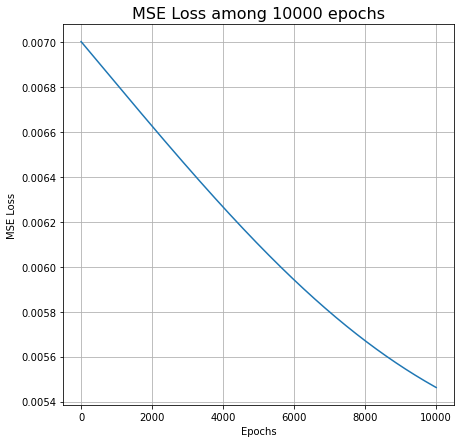

In [174]:
one.plot_loss()

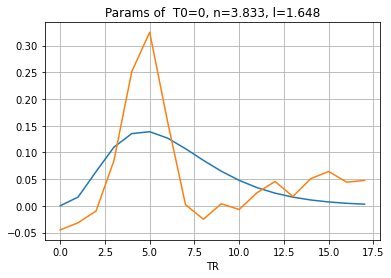

In [175]:
one.plot_gamma()

In [ ]:
two = LeastSquares(10000, 'ad', 2, (0, 4, 2, .3, 7, 2), 1e-3)
two.fit()

0     th Epochs
Prediction:: [ 0.          0.00631605  0.03057998  0.06222586  0.08841905  0.10270645
  0.10445949  0.09632798  0.08205406  0.06514092  0.04825353  0.03309379
  0.02052407  0.01078439  0.00371421 -0.00106336 -0.00400766 -0.00557416]
LOSS:: 0.006881467356991392, Gradient:: [-1.8524617603765667e-06, 3.999998110422096, 1.9999969032158862, 0.2999995658091223, 6.999999850259537, 1.9999994808857346]


1     th Epochs
Prediction:: [ 0.          0.00631611  0.03058019  0.0622262   0.08841943  0.10270677
  0.1044597   0.09632807  0.08205405  0.06514083  0.04825339  0.03309363
  0.02052391  0.01078425  0.00371409 -0.00106346 -0.00400774 -0.00557422]
LOSS:: 0.006881453716000131, Gradient:: [nan, 3.9999962208519984, 1.999993806430905, 0.2999991316113057, 6.999999700517339, 1.9999989617688672]


2     th Epochs
Prediction:: [ 0.          0.00631617  0.03058041  0.06222655  0.0884198   0.10270708
  0.10445991  0.09632816  0.08205403  0.06514074  0.04825325  0.03309348
  0.02052376  0

<ipython-input-38-b671dedc2bf4>:7: RuntimeWarning: invalid value encountered in power
  term1 = (t - t0)**(n1-1) / (l1**n1 * math.gamma(n1)) * np.exp(-t/l1)
<ipython-input-38-b671dedc2bf4>:8: RuntimeWarning: invalid value encountered in power
  term2 = (t - t0)**(n2-1) / (l2**n2 * math.gamma(n2)) * np.exp(-t/l2)


LOSS:: 0.006879584965489998, Gradient:: [nan, 3.9997374065174554, 1.9995695300581906, 0.29993959249461327, 6.999979185229084, 1.9999278445152875]


139   th Epochs
Prediction:: [ 0.          0.00632405  0.0306099   0.06227365  0.08847123  0.10275057
  0.10448854  0.09634039  0.08205201  0.06512832  0.04823461  0.0330722
  0.02050252  0.01076464  0.00369719 -0.00107732 -0.00401865 -0.00558249]
LOSS:: 0.006879571325440713, Gradient:: [nan, 3.999735517777423, 1.9995664330286134, 0.29993915750836486, 6.999979035477345, 1.9999273254244407]


140   th Epochs
Prediction:: [ 0.          0.00632411  0.03061011  0.06227399  0.08847161  0.10275089
  0.10448875  0.09634048  0.08205199  0.06512823  0.04823447  0.03307205
  0.02050237  0.0107645   0.00369707 -0.00107742 -0.00401872 -0.00558255]
LOSS:: 0.006879557685412718, Gradient:: [nan, 3.999733629039125, 1.9995633359981688, 0.29993872251517756, 6.999978885723005, 1.999926806330992]


141   th Epochs
Prediction:: [ 0.          0.00632417  0.03061

LOSS:: 0.006877498120164016, Gradient:: [nan, 3.9994484991177206, 1.9990956638992068, 0.2998729727970076, 6.9999562719944075, 1.9998484253279143]


292   th Epochs
Prediction:: [ 0.          0.00633287  0.03064285  0.06232628  0.08852868  0.10279914
  0.10452049  0.09635403  0.08204971  0.06511444  0.04821378  0.03304843
  0.02047881  0.01074292  0.00367848 -0.00109267 -0.00403072 -0.00559164]
LOSS:: 0.006877484481200122, Gradient:: [nan, 3.999446611297959, 1.9990925665990127, 0.2998725369329891, 6.999956122227056, 1.9998479062604864]


293   th Epochs
Prediction:: [ 0.          0.00633292  0.03064307  0.06232662  0.08852906  0.10279946
  0.1045207   0.09635412  0.0820497   0.06511435  0.04821364  0.03304828
  0.02047866  0.01074277  0.00367836 -0.00109277 -0.0040308  -0.0055917 ]
LOSS:: 0.006877470842233523, Gradient:: [nan, 3.999444723481667, 1.9990894692936143, 0.29987210106116435, 6.999955972458838, 1.9998473871930584]


294   th Epochs
Prediction:: [ 0.          0.00633298  0.0306

  0.02045418  0.01072035  0.00365904 -0.00110861 -0.00404325 -0.00560113]
LOSS:: 0.006875315974933872, Gradient:: [nan, 3.999146524699162, 1.9986000736723637, 0.2998031616774488, 6.999932308204252, 1.9997653768683123]


452   th Epochs
Prediction:: [ 0.          0.0063421   0.03067735  0.06238135  0.08858879  0.10284993
  0.10455389  0.09636826  0.08204729  0.06509989  0.04819197  0.03302358
  0.02045402  0.01072021  0.00365892 -0.00110871 -0.00404333 -0.00560119]
LOSS:: 0.0068753023371069324, Gradient:: [nan, 3.9991446378456414, 1.9985969760954811, 0.2998027248974963, 6.99993215842389, 1.9997648578303746]


453   th Epochs
Prediction:: [ 0.          0.00634215  0.03067757  0.0623817   0.08858916  0.10285025
  0.10455409  0.09636835  0.08204727  0.0650998   0.04819184  0.03302342
  0.02045387  0.01072006  0.0036588  -0.00110881 -0.00404341 -0.00560125]
LOSS:: 0.006875288699291078, Gradient:: [nan, 3.999142750997325, 1.9985938785133945, 0.29980228811060494, 6.999932008641794, 1.99976433

  0.02042768  0.01069609  0.00363816 -0.00112573 -0.00405671 -0.00561132]
LOSS:: 0.006872984011125027, Gradient:: [nan, 3.998823960544959, 1.9980703625189506, 0.2997283888792526, 6.999906694388498, 1.9996766237384656]


623   th Epochs
Prediction:: [ 0.          0.00635197  0.03071426  0.06244026  0.08865304  0.10290421
  0.10458956  0.09638344  0.08204466  0.06508432  0.04816866  0.032997
  0.02042753  0.01069595  0.00363804 -0.00112583 -0.00405679 -0.00561138]
LOSS:: 0.006872970374527886, Gradient:: [nan, 3.998822074722731, 1.998067264644563, 0.2997279511191814, 6.999906544591656, 1.999676104729151]


624   th Epochs
Prediction:: [ 0.          0.00635203  0.03071448  0.0624406   0.08865342  0.10290453
  0.10458976  0.09638352  0.08204465  0.06508423  0.04816852  0.03299685
  0.02042737  0.0106958   0.00363791 -0.00112593 -0.00405687 -0.00561144]
LOSS:: 0.006872956737942638, Gradient:: [nan, 3.998820188910912, 1.9980641667701753, 0.2997275133530386, 6.9999063947956826, 1.9996755857207

  0.02040274  0.01067326  0.00361851 -0.00114183 -0.00406936 -0.00562089]
LOSS:: 0.00687078861636051, Gradient:: [nan, 3.9985204217571075, 1.997571582786159, 0.2996578356684096, 6.999882576155919, 1.999593065604963]


784   th Epochs
Prediction:: [ 0.          0.00636129  0.03074905  0.06249575  0.08871357  0.10295531
  0.10462312  0.09639769  0.08204216  0.06506963  0.04814668  0.03297198
  0.02040259  0.01067312  0.00361839 -0.00114193 -0.00406944 -0.00562095]
LOSS:: 0.0068707749809782965, Gradient:: [nan, 3.9985185369123966, 1.9975684846368178, 0.29965739698546545, 6.9998824263451995, 1.9995925466242712]


785   th Epochs
Prediction:: [ 0.          0.00636134  0.03074926  0.0624961   0.08871394  0.10295563
  0.10462333  0.09639778  0.08204214  0.06506954  0.04814655  0.03297182
  0.02040243  0.01067297  0.00361827 -0.00114203 -0.00406952 -0.00562101]
LOSS:: 0.0068707613455917475, Gradient:: [nan, 3.9985166520763595, 1.9975653864874765, 0.29965695829905187, 6.999882276536215, 1.99959


952   th Epochs
Prediction:: [ 0.          0.00637102  0.03078538  0.0625537   0.08877674  0.10300863
  0.10465812  0.09641254  0.08203951  0.06505428  0.04812374  0.03294586
  0.02037657  0.01064931  0.0035979  -0.0011587  -0.00408262 -0.00563092]
LOSS:: 0.006868484343362781, Gradient:: [nan, 3.9982019697406206, 1.9970479716195813, 0.2995836169261465, 6.999857257086162, 1.9995053605256528]


953   th Epochs
Prediction:: [ 0.          0.00637107  0.0307856   0.06255405  0.08877712  0.10300895
  0.10465833  0.09641263  0.08203949  0.06505418  0.04812361  0.0329457
  0.02037642  0.01064916  0.00359778 -0.0011588  -0.0040827  -0.00563098]
LOSS:: 0.006868470709250349, Gradient:: [nan, 3.9982000859254683, 1.9970448731857453, 0.29958317727522665, 6.999857107262432, 1.9995048415770533]


954   th Epochs
Prediction:: [ 0.          0.00637113  0.03078581  0.06255439  0.0887775   0.10300927
  0.10465853  0.09641271  0.08203948  0.06505409  0.04812347  0.03294555
  0.02037626  0.01064902  0.0035

LOSS:: 0.006866289352250788, Gradient:: [nan, 3.9978987542098188, 1.9965491021816337, 0.29951275926786397, 6.999833134286919, 1.9994218120467517]


1114  th Epochs
Prediction:: [ 0.          0.00638041  0.03082045  0.06260962  0.08883769  0.10306005
  0.10469185  0.09642682  0.08203693  0.06503945  0.0481016   0.03292067
  0.02035148  0.01062636  0.00357817 -0.00117487 -0.00409531 -0.00564052]
LOSS:: 0.006866275719393723, Gradient:: [nan, 3.9978968713782543, 1.9965460034806504, 0.29951231869407124, 6.9998329844510465, 1.9994212931276427]


1115  th Epochs
Prediction:: [ 0.          0.00638047  0.03082067  0.06260996  0.08883806  0.10306037
  0.10469206  0.09642691  0.08203691  0.06503935  0.04810147  0.03292051
  0.02035133  0.01062621  0.00357804 -0.00117497 -0.00409539 -0.00564058]
LOSS:: 0.006866262086553884, Gradient:: [nan, 3.9978949885527615, 1.9965429047753303, 0.29951187811507435, 6.999832834613439, 1.999420774209401]


1116  th Epochs
Prediction:: [ 0.          0.00638053  0.0

In [ ]:
two.plot_loss()

In [ ]:
two.plot_gamma()

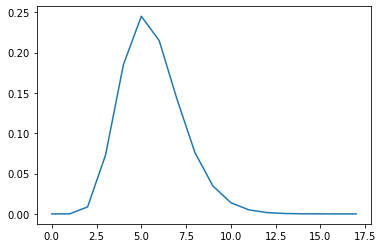

In [106]:
plt.plot(one_gamma(params))